In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 12
IN_CHANNELS = 1
N_CLASSES = 1
EPOCH =100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
ACT = "sigmoid"
AUX_PARAM = None

### Optimizer Settings

In [8]:
OPTIM_NAME = "adam"
init_lr = 3e-4
momentum = 0.9

# Epochs

In [9]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor

In [10]:
def train_epoch(model, optimizer, dataloader, device):
  
    # change mode to train and move to current device
    model = model.train().to(device)

    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]

        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())
        
        _loss = _ssim + _mae + air_loss + bone_loss
                        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        

    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1)

In [11]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]

        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]

        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]       
        
    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), sum(air_)/len(air_), sum(bone_)/len(bone_)

In [32]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1


# Read Data

In [13]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [14]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [15]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [16]:
len(trainset), len(testset)

(1344, 191)

In [17]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f49e81ff640>,)

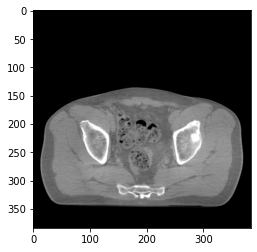

In [18]:
plt.imshow(x.squeeze(), 'gray'),

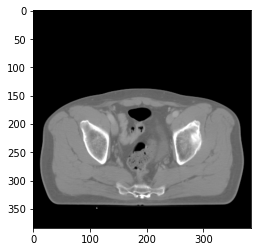

In [19]:
plt.imshow(y.squeeze(), 'gray')

In [20]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

In [21]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

# training

In [22]:
import wandb

wandb.init(project="cbct", config={
    "data": {
        "in_channels": IN_CHANNELS,
        "out_channels": N_CLASSES,
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "optimizer": OPTIM_NAME,
        "init_lr": init_lr,
        "momentum": momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": ACT,
        "decoder_attention_type": DECODER_ATT
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [23]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)

In [24]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
optimizer = Optimizer(model.parameters(), name=OPTIM_NAME, lr=init_lr)

In [25]:
wandb.watch(model)

min_mae = 99999

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone = train_epoch(model, optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train = eval_epoch(model, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test = eval_epoch(model, testloader, device)

        
        wandb.log({
            "ssim loss": loss_ssim,
            "mae loss": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test
        })
        
        
        if score_mae_test < min_mae:
            min_mae = score_mae_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("{}.pth".format(wandb.run.name)))

112it [01:54,  1.02s/it]
112it [00:31,  3.55it/s]
16it [00:04,  3.22it/s]
112it [01:47,  1.04it/s]
112it [00:31,  3.56it/s]
16it [00:04,  3.64it/s]
112it [01:51,  1.01it/s]
112it [00:31,  3.57it/s]
16it [00:04,  3.21it/s]
112it [01:51,  1.00it/s]
112it [00:31,  3.55it/s]
16it [00:04,  3.21it/s]
112it [01:50,  1.01it/s]
112it [00:30,  3.62it/s]
16it [00:05,  3.14it/s]
112it [01:47,  1.04it/s]
112it [00:31,  3.55it/s]
16it [00:05,  3.20it/s]
112it [01:46,  1.06it/s]
112it [00:31,  3.58it/s]
16it [00:04,  3.20it/s]
112it [01:51,  1.00it/s]
112it [00:31,  3.56it/s]
16it [00:04,  3.21it/s]
112it [01:51,  1.01it/s]
112it [00:30,  3.66it/s]
16it [00:05,  3.20it/s]
112it [01:51,  1.01it/s]
112it [00:31,  3.55it/s]
16it [00:05,  3.19it/s]
112it [01:51,  1.00it/s]
112it [00:31,  3.57it/s]
16it [00:05,  3.19it/s]
112it [01:50,  1.02it/s]
112it [00:30,  3.65it/s]
16it [00:05,  3.14it/s]
112it [01:47,  1.04it/s]
112it [00:31,  3.57it/s]
16it [00:04,  3.22it/s]
112it [01:51,  1.00it/s]
112it [00:31,

In [26]:
run_name = wandb.run.name
# run_name = "dandy-dream-44"

In [28]:
checkpoint = torch.load(os.path.join("weight-unet", "{}.pth".format(run_name)))

In [ ]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)
model.load_state_dict(checkpoint["model"])

In [29]:
try:
    os.mkdir(os.path.join("eval-unet", run_name))
except FileExistsError:
    print("file exists")

0it [00:00, ?it/s]

ssim score = 0.8959528207778931
psnr score = 25.81791877746582
snr score = 15.880855560302734
mae error = 0.01744765415787697
air dice score = 0.997710206081455
bone dice score = 0.9687363676026067


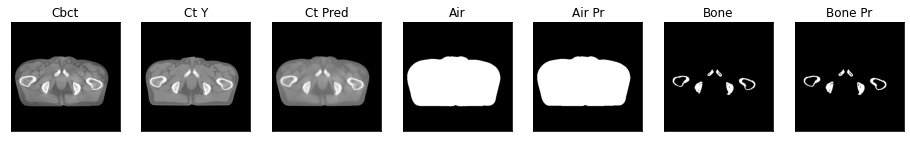

ssim score = 0.8961267471313477
psnr score = 25.69127655029297
snr score = 15.801748275756836
mae error = 0.01769794337451458
air dice score = 0.9977425283682299
bone dice score = 0.9701686121923884


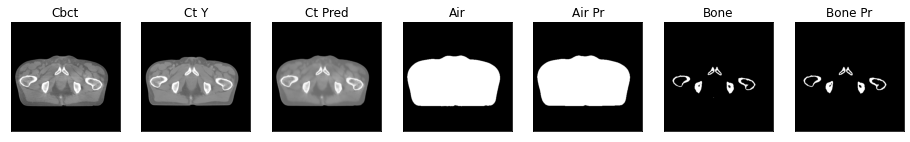

ssim score = 0.8936127424240112
psnr score = 25.54589080810547
snr score = 15.819259643554688
mae error = 0.018763931468129158
air dice score = 0.9973994278741349
bone dice score = 0.9648531535873272


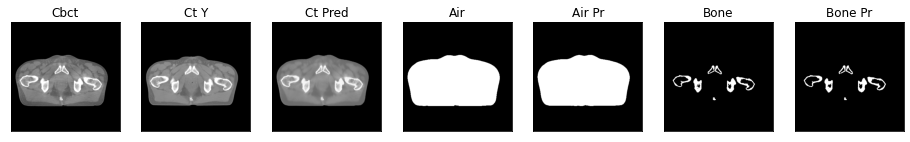

ssim score = 0.8911197781562805
psnr score = 25.647186279296875
snr score = 16.009809494018555
mae error = 0.018795665353536606
air dice score = 0.9972142613784424
bone dice score = 0.9558553696712806


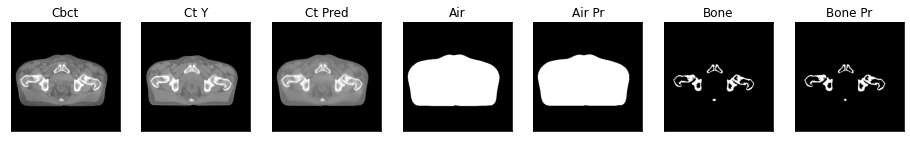

ssim score = 0.8900845646858215
psnr score = 25.801467895507812
snr score = 16.20439338684082
mae error = 0.018352685496211052
air dice score = 0.997658032546314
bone dice score = 0.9556612011258789


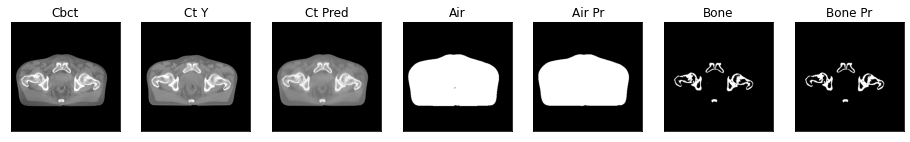

ssim score = 0.8854680061340332
psnr score = 25.74789047241211
snr score = 16.287349700927734
mae error = 0.018909968435764313
air dice score = 0.9979112640384268
bone dice score = 0.9562061855673715


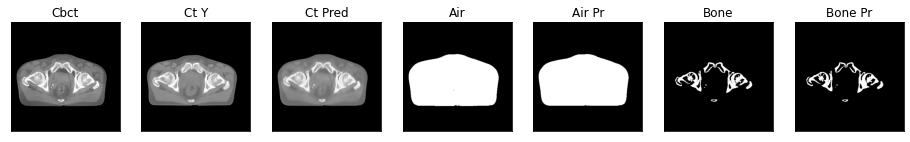

ssim score = 0.8840716481208801
psnr score = 25.57366371154785
snr score = 16.089065551757812
mae error = 0.01925768330693245
air dice score = 0.9977850930667339
bone dice score = 0.9583167923782587


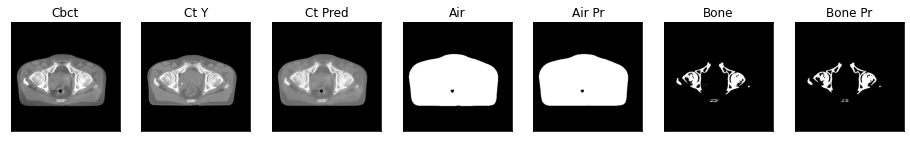

ssim score = 0.8863120079040527
psnr score = 25.913923263549805
snr score = 16.243785858154297
mae error = 0.018562689423561096
air dice score = 0.9977826144712529
bone dice score = 0.9647573240055553


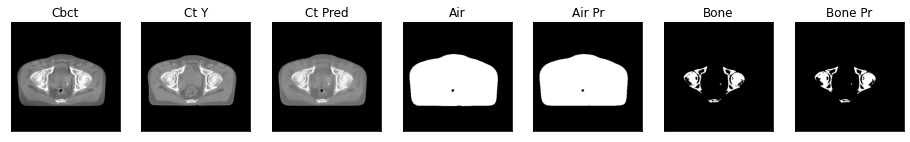

ssim score = 0.8908248543739319
psnr score = 26.30771255493164
snr score = 16.54302215576172
mae error = 0.01776820421218872
air dice score = 0.9978634673459766
bone dice score = 0.9687500000002978


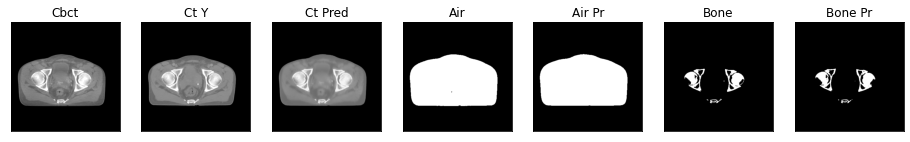

ssim score = 0.8942384123802185
psnr score = 26.332489013671875
snr score = 16.552515029907227
mae error = 0.017769047990441322
air dice score = 0.9979705102717052
bone dice score = 0.9627575277341248


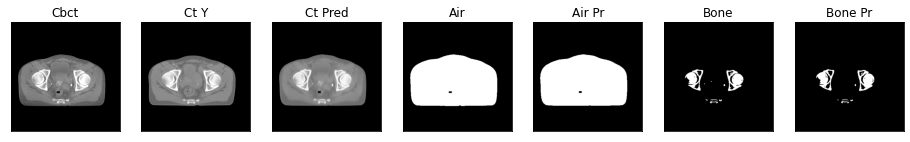

ssim score = 0.9003809094429016
psnr score = 26.616455078125
snr score = 16.868751525878906
mae error = 0.01758386380970478
air dice score = 0.9980204209210273
bone dice score = 0.9729615547108897


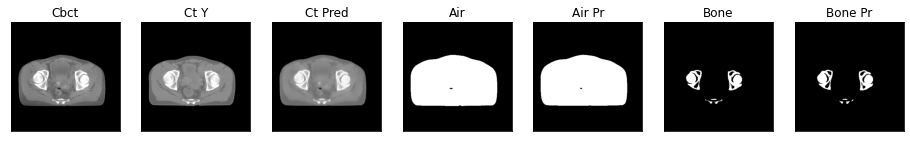

ssim score = 0.9007663130760193
psnr score = 25.80994415283203
snr score = 16.085948944091797
mae error = 0.018707314506173134
air dice score = 0.9979134613358085
bone dice score = 0.975728155340062


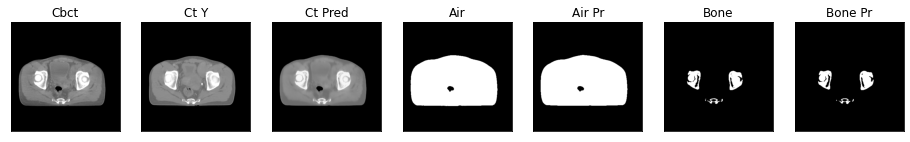

1it [00:23, 23.99s/it]

ssim score = 0.904898464679718
psnr score = 25.1381893157959
snr score = 15.382275581359863
mae error = 0.0193494763225317
air dice score = 0.9977610030706268
bone dice score = 0.9751728828933774


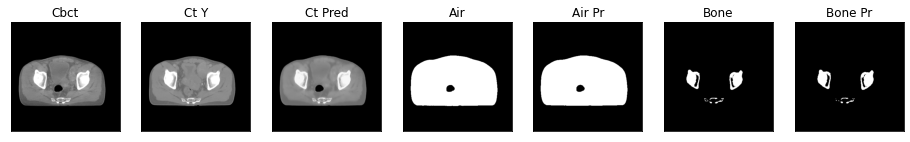

ssim score = 0.901603102684021
psnr score = 24.934728622436523
snr score = 15.03685474395752
mae error = 0.01916949450969696
air dice score = 0.9979470533228737
bone dice score = 0.9632571996032366


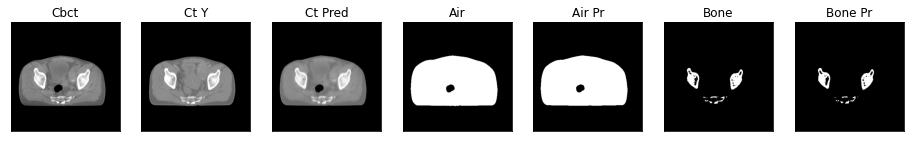

ssim score = 0.8993288278579712
psnr score = 24.864028930664062
snr score = 14.88049602508545
mae error = 0.019124116748571396
air dice score = 0.9979432332373531
bone dice score = 0.9532217683495424


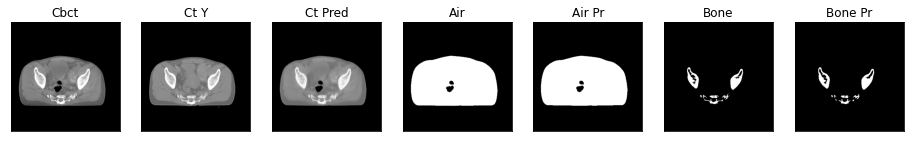

ssim score = 0.8934070467948914
psnr score = 24.570819854736328
snr score = 14.610771179199219
mae error = 0.019792836159467697
air dice score = 0.9970509820991381
bone dice score = 0.9620443442319674


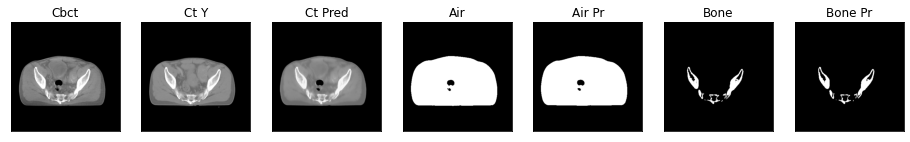

ssim score = 0.8896536231040955
psnr score = 23.85622215270996
snr score = 13.893630981445312
mae error = 0.021107232198119164
air dice score = 0.9970254489368767
bone dice score = 0.9606168446030768


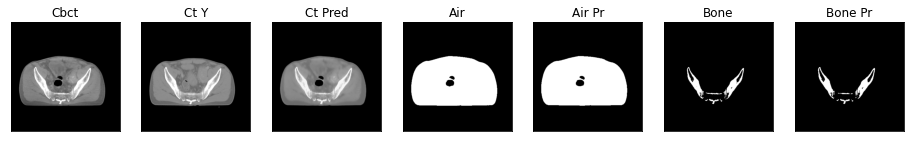

ssim score = 0.882387101650238
psnr score = 23.264366149902344
snr score = 13.200011253356934
mae error = 0.02214778959751129
air dice score = 0.9968188058801898
bone dice score = 0.9531024531030169


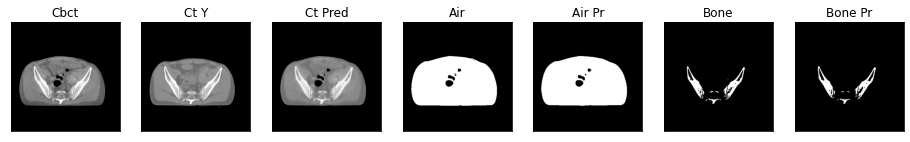

ssim score = 0.881687343120575
psnr score = 23.037738800048828
snr score = 12.92270278930664
mae error = 0.02240143157541752
air dice score = 0.9967219024230923
bone dice score = 0.9469204397689215


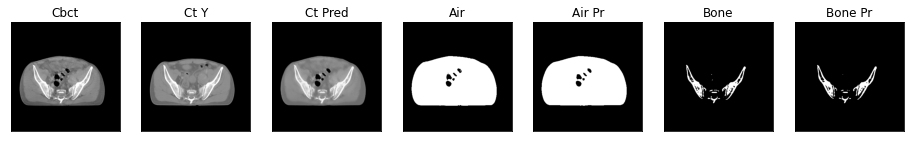

ssim score = 0.8849454522132874
psnr score = 23.041765213012695
snr score = 12.914421081542969
mae error = 0.02251025103032589
air dice score = 0.9968064866823736
bone dice score = 0.9479585618531631


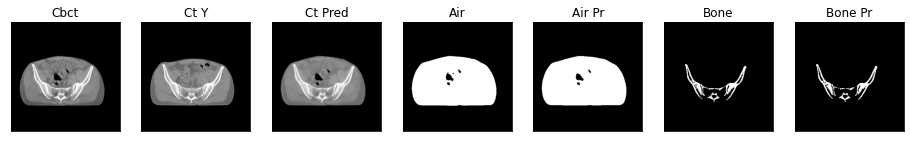

ssim score = 0.883188784122467
psnr score = 22.945552825927734
snr score = 12.753361701965332
mae error = 0.022560257464647293
air dice score = 0.9975267554907196
bone dice score = 0.9388628762549985


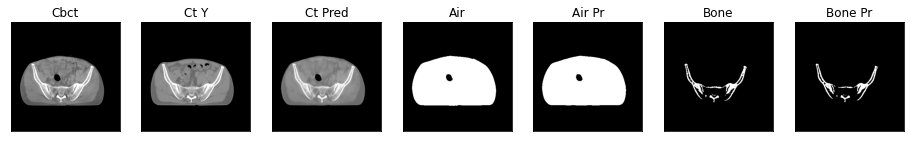

ssim score = 0.8810656070709229
psnr score = 22.96245765686035
snr score = 12.710837364196777
mae error = 0.02210582233965397
air dice score = 0.996532058298293
bone dice score = 0.9446117585446562


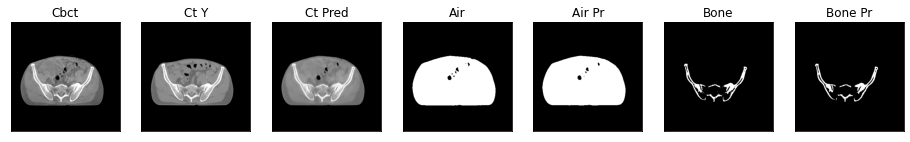

ssim score = 0.8854740262031555
psnr score = 23.150035858154297
snr score = 12.864989280700684
mae error = 0.021651336923241615
air dice score = 0.9966809024231772
bone dice score = 0.9506233194823928


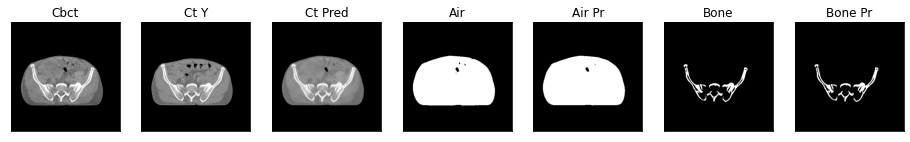

ssim score = 0.8845570683479309
psnr score = 23.12747573852539
snr score = 12.793861389160156
mae error = 0.021809343248605728
air dice score = 0.9972455019633156
bone dice score = 0.9496877577477354


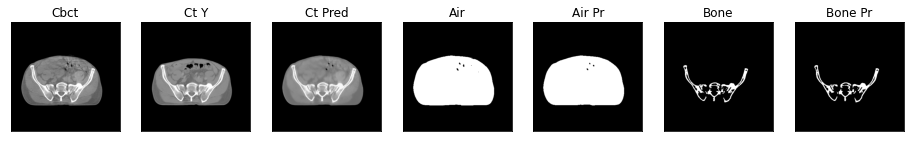

2it [00:27, 17.77s/it]

ssim score = 0.8839947581291199
psnr score = 23.039417266845703
snr score = 12.608803749084473
mae error = 0.02192733809351921
air dice score = 0.9978506881360386
bone dice score = 0.9486685552413748


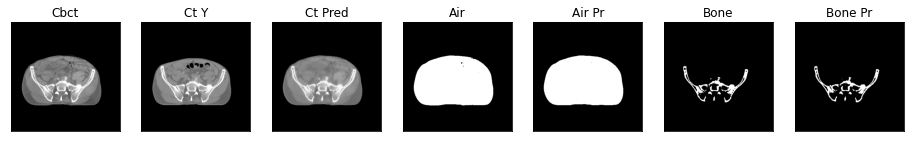

ssim score = 0.8865839242935181
psnr score = 23.188264846801758
snr score = 12.674915313720703
mae error = 0.02130165509879589
air dice score = 0.9978660976260362
bone dice score = 0.9415861604140464


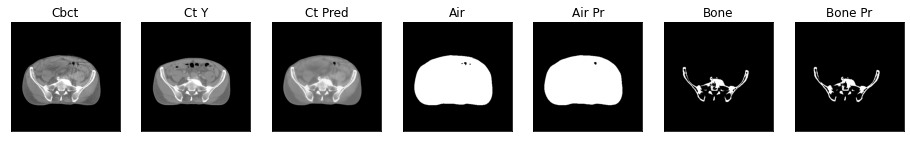

ssim score = 0.8866012096405029
psnr score = 23.328033447265625
snr score = 12.72349739074707
mae error = 0.02115422673523426
air dice score = 0.9977985010018084
bone dice score = 0.9514435695543368


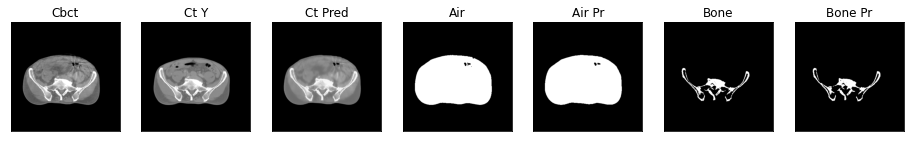

ssim score = 0.8881122469902039
psnr score = 23.214643478393555
snr score = 12.569003105163574
mae error = 0.02111121080815792
air dice score = 0.9974481778984583
bone dice score = 0.9503221783418175


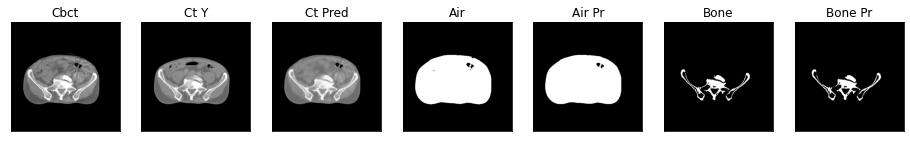

ssim score = 0.8681771159172058
psnr score = 23.68659210205078
snr score = 15.05875015258789
mae error = 0.02341424860060215
air dice score = 0.9986185859570833
bone dice score = 0.9864224818444451


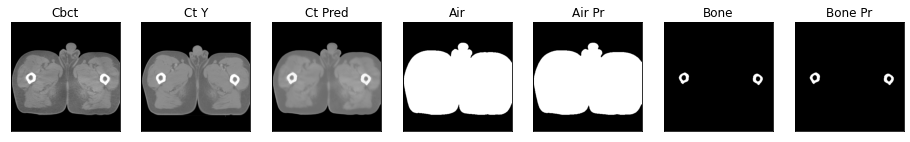

ssim score = 0.8737173080444336
psnr score = 24.256595611572266
snr score = 15.668010711669922
mae error = 0.022076614201068878
air dice score = 0.998698513826742
bone dice score = 0.9870206489679345


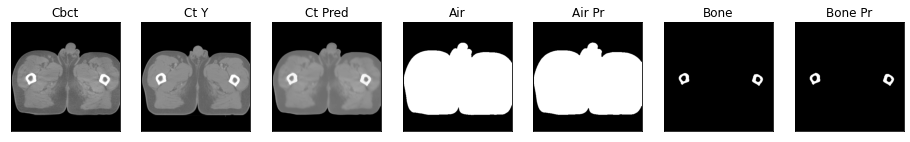

ssim score = 0.88204026222229
psnr score = 24.806440353393555
snr score = 16.305301666259766
mae error = 0.021088043227791786
air dice score = 0.9988862429467188
bone dice score = 0.9815118183950032


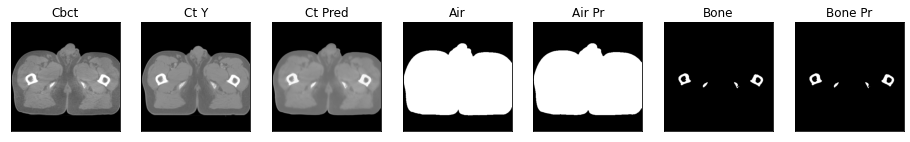

ssim score = 0.8865616321563721
psnr score = 25.229053497314453
snr score = 16.890472412109375
mae error = 0.020665477961301804
air dice score = 0.9988015311051602
bone dice score = 0.9811501597447101


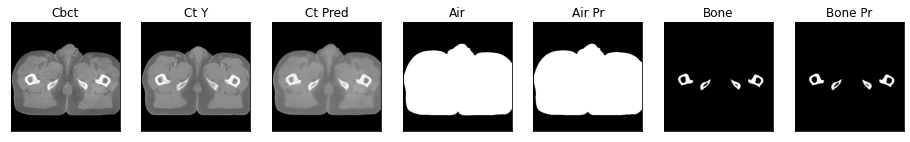

ssim score = 0.8896142244338989
psnr score = 25.58376693725586
snr score = 17.37333106994629
mae error = 0.020149199292063713
air dice score = 0.998885498693659
bone dice score = 0.9758454106283527


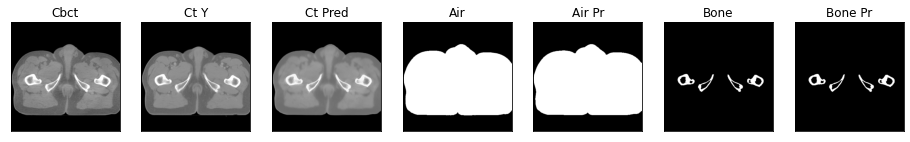

ssim score = 0.8920800089836121
psnr score = 26.052427291870117
snr score = 17.94523048400879
mae error = 0.019529590383172035
air dice score = 0.998750530721175
bone dice score = 0.9735894357746266


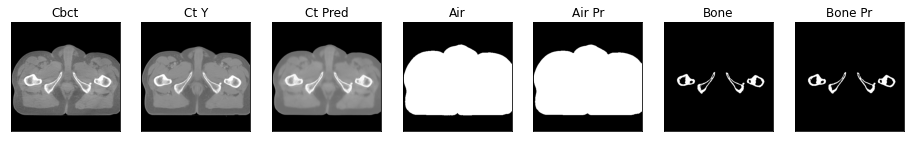

ssim score = 0.893119752407074
psnr score = 26.391324996948242
snr score = 18.351228713989258
mae error = 0.01968940906226635
air dice score = 0.9988457331407548
bone dice score = 0.9685230024216539


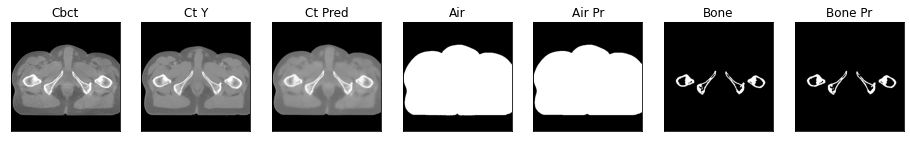

ssim score = 0.8926557898521423
psnr score = 26.45281982421875
snr score = 18.402833938598633
mae error = 0.019520843401551247
air dice score = 0.9989217581967467
bone dice score = 0.9727367325705231


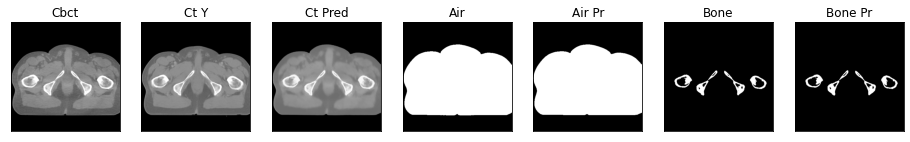

3it [00:30, 13.42s/it]

ssim score = 0.8949235081672668
psnr score = 26.55825424194336
snr score = 18.494604110717773
mae error = 0.019177695736289024
air dice score = 0.9986471454769572
bone dice score = 0.9771181199754987


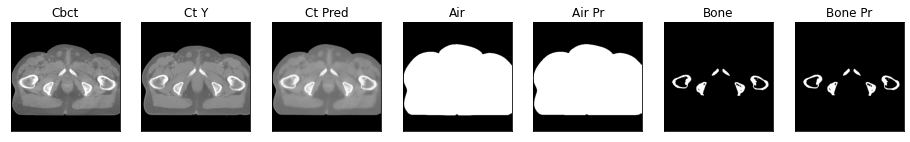

ssim score = 0.8947902321815491
psnr score = 26.605146408081055
snr score = 18.553495407104492
mae error = 0.019396787509322166
air dice score = 0.9986909737233999
bone dice score = 0.9726906756612699


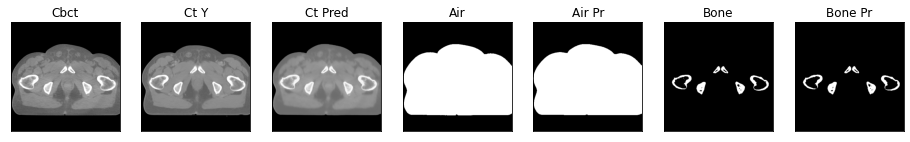

ssim score = 0.8968797326087952
psnr score = 26.730775833129883
snr score = 18.718210220336914
mae error = 0.019029540941119194
air dice score = 0.9987335922166946
bone dice score = 0.9675114435640559


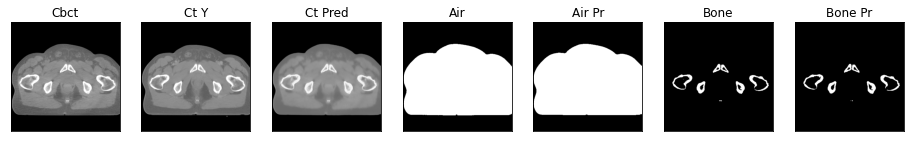

ssim score = 0.8940038681030273
psnr score = 26.726032257080078
snr score = 18.854753494262695
mae error = 0.019476596266031265
air dice score = 0.9985111185822015
bone dice score = 0.9676063067370511


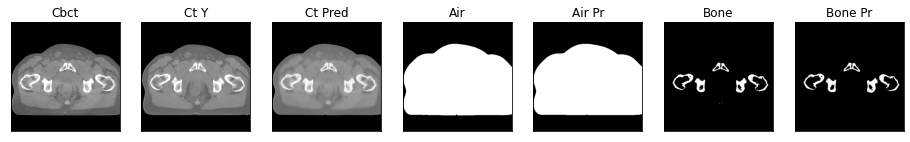

ssim score = 0.893295168876648
psnr score = 26.850614547729492
snr score = 19.074024200439453
mae error = 0.019677983596920967
air dice score = 0.9984912329211784
bone dice score = 0.9700285442438152


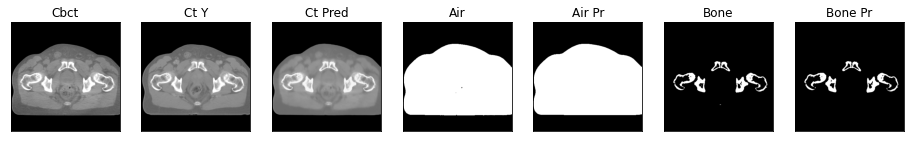

ssim score = 0.8849483132362366
psnr score = 26.231616973876953
snr score = 18.420984268188477
mae error = 0.021054834127426147
air dice score = 0.9978818289893742
bone dice score = 0.9595920574831215


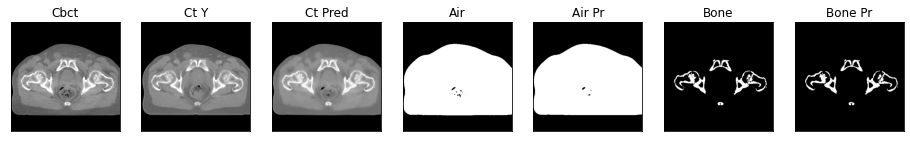

ssim score = 0.8855376839637756
psnr score = 25.734142303466797
snr score = 17.995691299438477
mae error = 0.02113780938088894
air dice score = 0.997635330233125
bone dice score = 0.9539070227500567


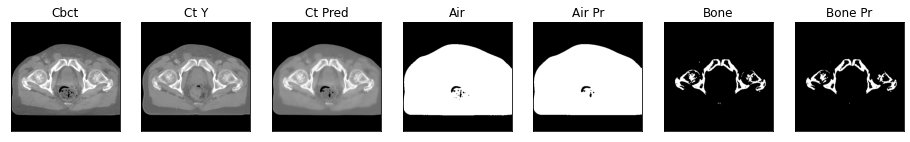

ssim score = 0.8833882808685303
psnr score = 25.755859375
snr score = 17.88131332397461
mae error = 0.020968135446310043
air dice score = 0.997908727860258
bone dice score = 0.9403267411870995


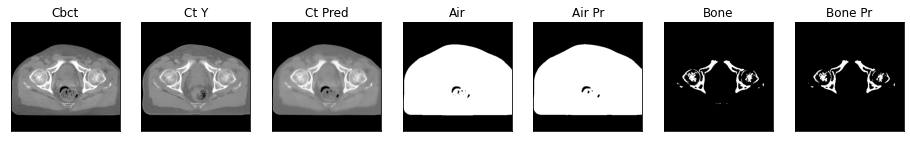

ssim score = 0.8900851011276245
psnr score = 25.879823684692383
snr score = 17.826717376708984
mae error = 0.020054062828421593
air dice score = 0.9982582549548074
bone dice score = 0.9380993897128925


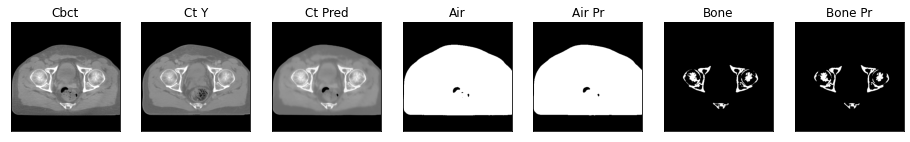

ssim score = 0.8899403810501099
psnr score = 26.02329444885254
snr score = 17.879600524902344
mae error = 0.02007763646543026
air dice score = 0.9983603749112899
bone dice score = 0.9315400727600976


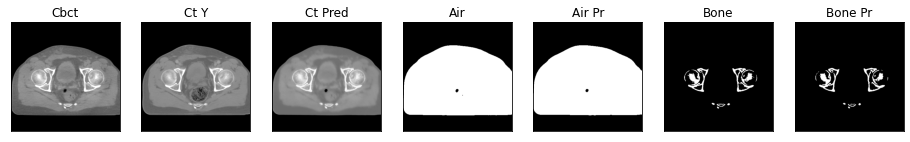

ssim score = 0.8895217776298523
psnr score = 26.02764892578125
snr score = 17.89964485168457
mae error = 0.019849903881549835
air dice score = 0.9984158172663647
bone dice score = 0.9483778820654114


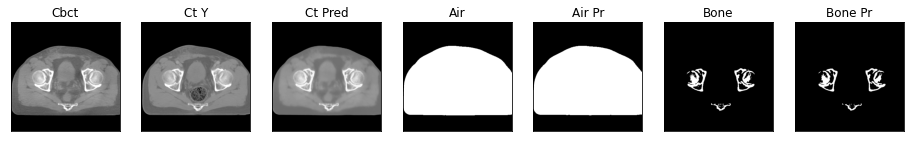

ssim score = 0.8797776699066162
psnr score = 25.781545639038086
snr score = 17.663576126098633
mae error = 0.02099371887743473
air dice score = 0.9983518823725497
bone dice score = 0.9557232475683632


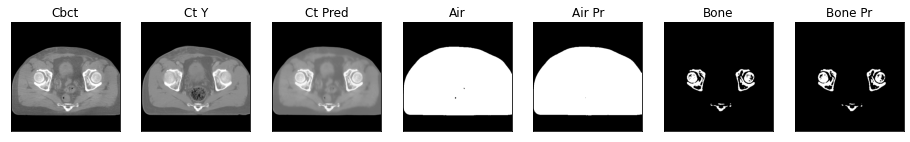

4it [00:33, 10.38s/it]

ssim score = 0.887479841709137
psnr score = 26.222370147705078
snr score = 18.165990829467773
mae error = 0.02030164562165737
air dice score = 0.9985316440011162
bone dice score = 0.970099079971956


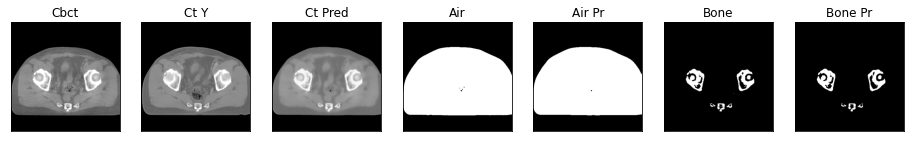

ssim score = 0.8875571489334106
psnr score = 26.586990356445312
snr score = 18.600692749023438
mae error = 0.020453687757253647
air dice score = 0.9983665306477368
bone dice score = 0.9760773814666545


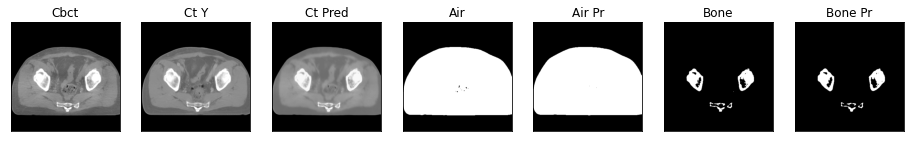

ssim score = 0.8869853615760803
psnr score = 26.074474334716797
snr score = 17.969072341918945
mae error = 0.02081367000937462
air dice score = 0.9981548325370754
bone dice score = 0.9706559263524103


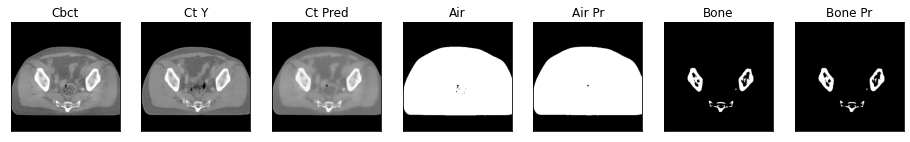

ssim score = 0.880585789680481
psnr score = 25.458702087402344
snr score = 17.434926986694336
mae error = 0.02267731912434101
air dice score = 0.9977634472732708
bone dice score = 0.973217274857941


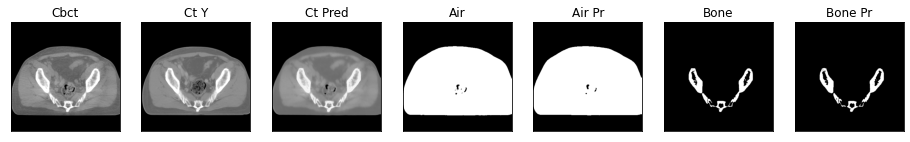

ssim score = 0.8805029392242432
psnr score = 25.50590705871582
snr score = 17.56227684020996
mae error = 0.022737542167305946
air dice score = 0.997820674411242
bone dice score = 0.9753009114313275


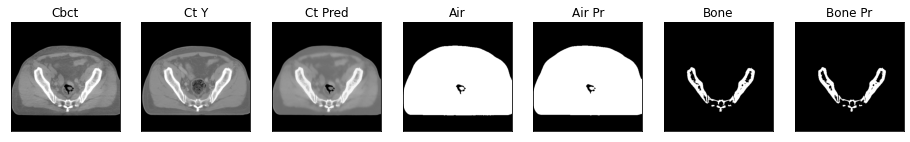

ssim score = 0.8698725700378418
psnr score = 25.0432186126709
snr score = 17.121145248413086
mae error = 0.024310719221830368
air dice score = 0.9980258801542178
bone dice score = 0.9648522115857393


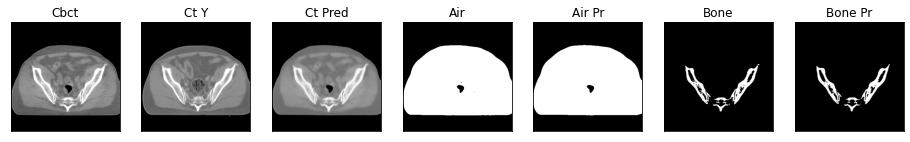

ssim score = 0.8720484972000122
psnr score = 25.532176971435547
snr score = 17.622644424438477
mae error = 0.023661531507968903
air dice score = 0.9980972723478443
bone dice score = 0.972834952833727


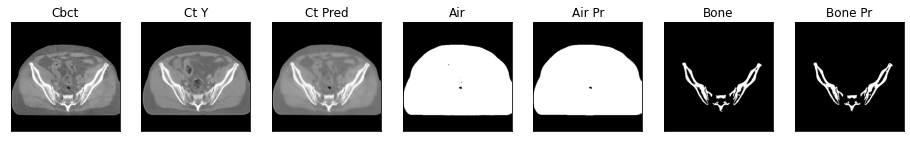

ssim score = 0.815230667591095
psnr score = 20.664997100830078
snr score = 10.545205116271973
mae error = 0.035222429782152176
air dice score = 0.9908455205082984
bone dice score = 0.9711776008791881


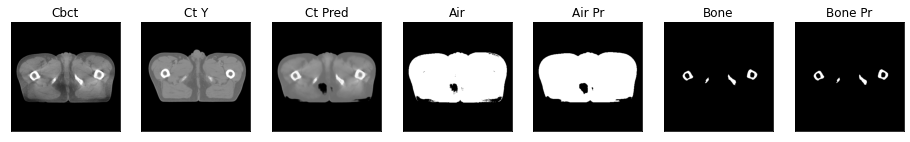

ssim score = 0.8045020699501038
psnr score = 20.35600471496582
snr score = 10.44919204711914
mae error = 0.0373697467148304
air dice score = 0.9921170012811116
bone dice score = 0.9584438549964978


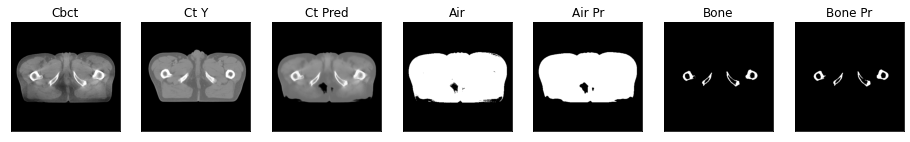

ssim score = 0.7986027002334595
psnr score = 20.327106475830078
snr score = 10.551433563232422
mae error = 0.03783313184976578
air dice score = 0.9917989294856954
bone dice score = 0.9366122535523296


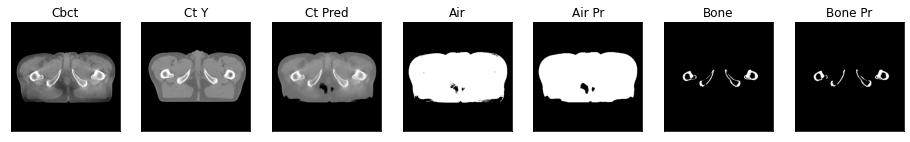

ssim score = 0.7968485355377197
psnr score = 20.392105102539062
snr score = 10.686834335327148
mae error = 0.03755524381995201
air dice score = 0.9917955514901557
bone dice score = 0.9380350591125554


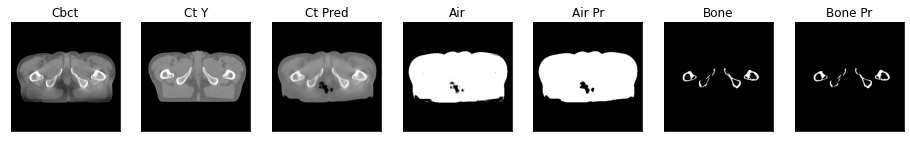

ssim score = 0.798061192035675
psnr score = 20.483516693115234
snr score = 10.825814247131348
mae error = 0.03743940219283104
air dice score = 0.9906517739327684
bone dice score = 0.934257425743876


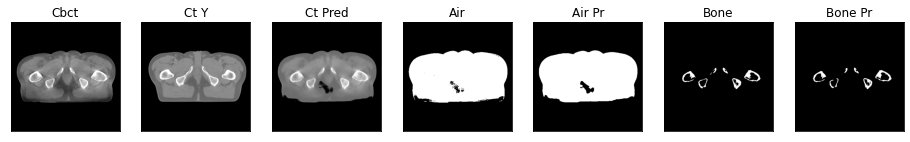

5it [00:37,  8.25s/it]

ssim score = 0.8015859723091125
psnr score = 20.686832427978516
snr score = 11.034744262695312
mae error = 0.03646120801568031
air dice score = 0.9913300948415532
bone dice score = 0.9445077917152317


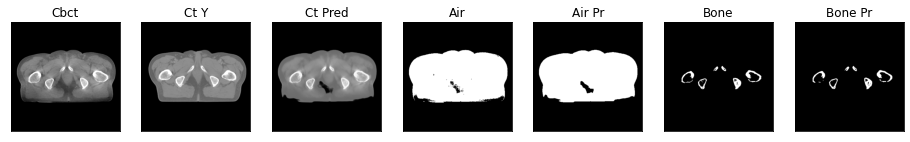

ssim score = 0.806452751159668
psnr score = 20.922039031982422
snr score = 11.263447761535645
mae error = 0.03510858118534088
air dice score = 0.9912549311705231
bone dice score = 0.9465972623877656


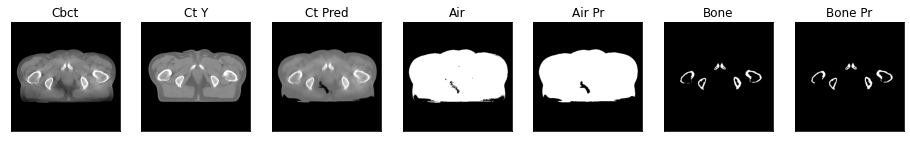

ssim score = 0.81124347448349
psnr score = 21.044872283935547
snr score = 11.400392532348633
mae error = 0.034412939101457596
air dice score = 0.9931504975237879
bone dice score = 0.9523987306337055


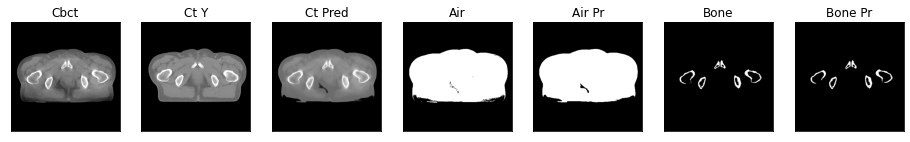

ssim score = 0.812130331993103
psnr score = 21.028751373291016
snr score = 11.442280769348145
mae error = 0.0348651297390461
air dice score = 0.9947274327770415
bone dice score = 0.9409803267765758


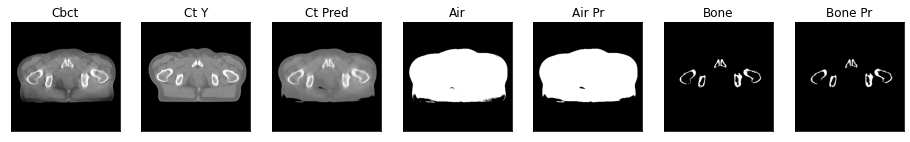

ssim score = 0.8050681948661804
psnr score = 20.869979858398438
snr score = 11.38206672668457
mae error = 0.0364234633743763
air dice score = 0.9954544631376923
bone dice score = 0.9245283018879992


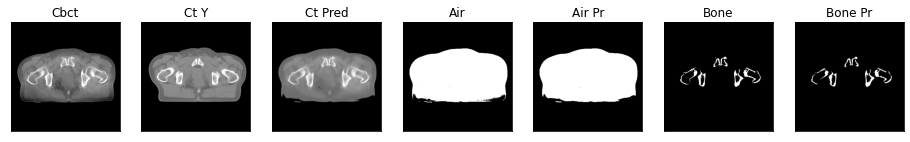

ssim score = 0.7950959205627441
psnr score = 20.79364013671875
snr score = 11.341554641723633
mae error = 0.037243686616420746
air dice score = 0.9945863873399238
bone dice score = 0.923193916350978


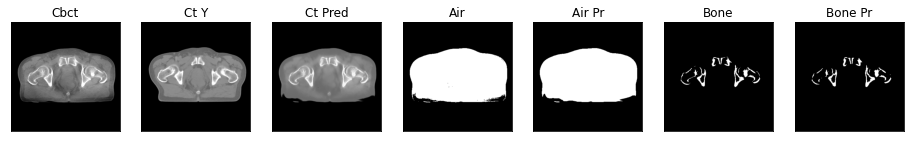

ssim score = 0.7833495140075684
psnr score = 20.689533233642578
snr score = 11.270153045654297
mae error = 0.03744809702038765
air dice score = 0.9940760005779565
bone dice score = 0.9019714479958943


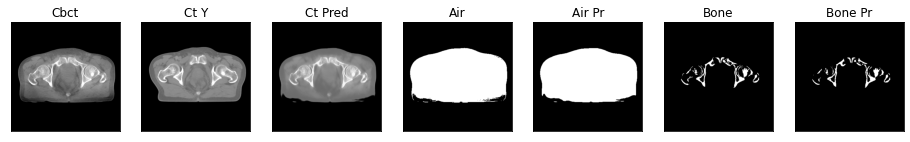

ssim score = 0.78403639793396
psnr score = 20.61039161682129
snr score = 11.307831764221191
mae error = 0.03834427520632744
air dice score = 0.9939240734889234
bone dice score = 0.9221250840629169


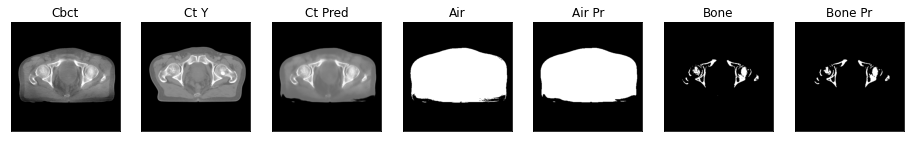

ssim score = 0.7866927981376648
psnr score = 20.46358299255371
snr score = 11.145033836364746
mae error = 0.038986701518297195
air dice score = 0.9929257428873514
bone dice score = 0.9106819553423252


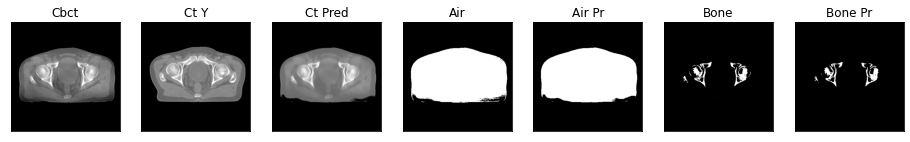

ssim score = 0.8002600073814392
psnr score = 20.900556564331055
snr score = 11.38284683227539
mae error = 0.03576163947582245
air dice score = 0.9930258432759604
bone dice score = 0.9340588988486866


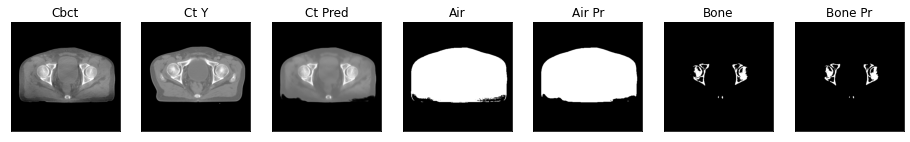

ssim score = 0.8152160048484802
psnr score = 21.531185150146484
snr score = 11.843082427978516
mae error = 0.03256961703300476
air dice score = 0.9925164042587873
bone dice score = 0.9546977421710896


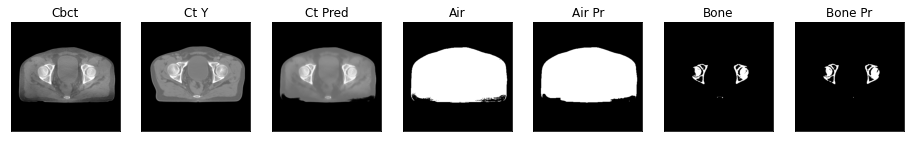

ssim score = 0.8220555186271667
psnr score = 21.790494918823242
snr score = 12.116557121276855
mae error = 0.031411804258823395
air dice score = 0.9920111463959757
bone dice score = 0.9585957389795177


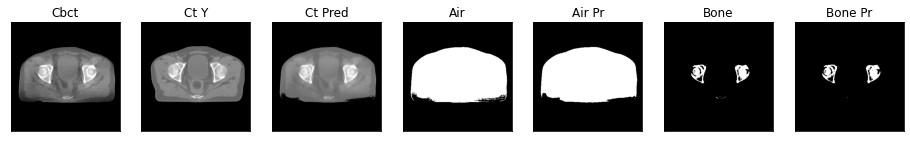

6it [00:40,  6.75s/it]

ssim score = 0.8266512155532837
psnr score = 21.92416000366211
snr score = 12.332052230834961
mae error = 0.03137245401740074
air dice score = 0.9919354838709751
bone dice score = 0.967715790896019


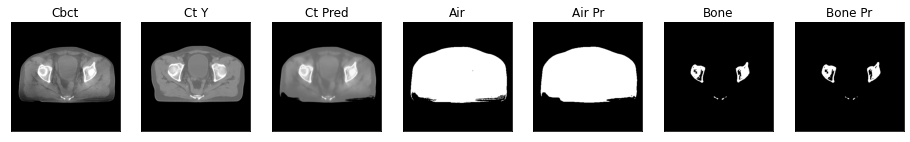

ssim score = 0.8245596885681152
psnr score = 21.635562896728516
snr score = 12.135628700256348
mae error = 0.03274921327829361
air dice score = 0.9922826676305871
bone dice score = 0.9544621026901824


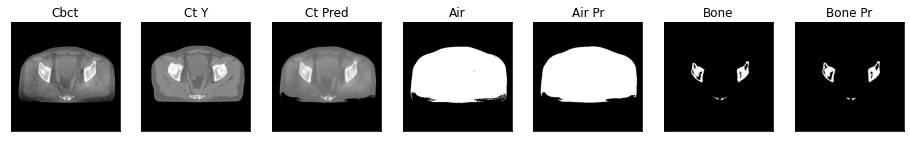

ssim score = 0.8220934271812439
psnr score = 21.983518600463867
snr score = 12.420156478881836
mae error = 0.031450193375349045
air dice score = 0.9920103185124216
bone dice score = 0.9715814108998398


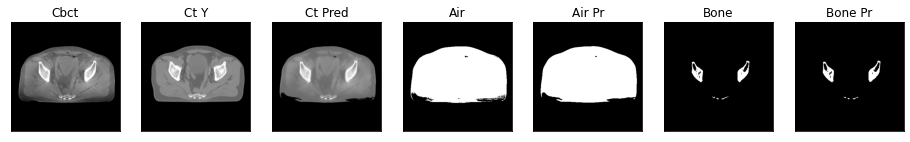

ssim score = 0.8266211152076721
psnr score = 22.207073211669922
snr score = 12.607318878173828
mae error = 0.03044014610350132
air dice score = 0.992024035194399
bone dice score = 0.9686082380698855


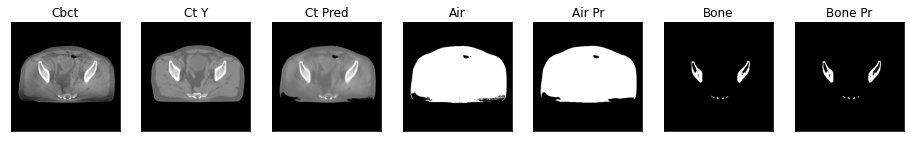

ssim score = 0.8234624266624451
psnr score = 22.09521484375
snr score = 12.533206939697266
mae error = 0.031485799700021744
air dice score = 0.9924048373421461
bone dice score = 0.9520295202960075


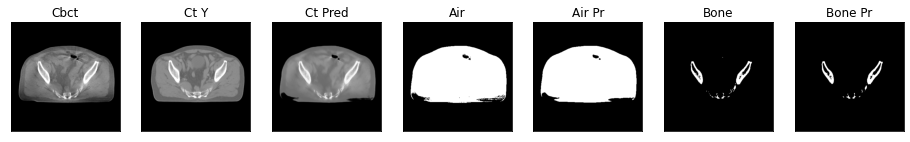

ssim score = 0.8183526396751404
psnr score = 22.088754653930664
snr score = 12.657247543334961
mae error = 0.03206693381071091
air dice score = 0.9914353192816796
bone dice score = 0.9512977544480709


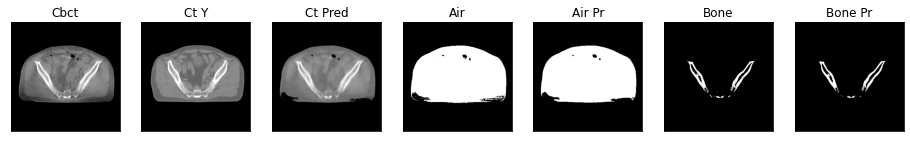

ssim score = 0.8196547031402588
psnr score = 22.06509017944336
snr score = 12.651334762573242
mae error = 0.032131221145391464
air dice score = 0.9915519119827184
bone dice score = 0.9325984251979118


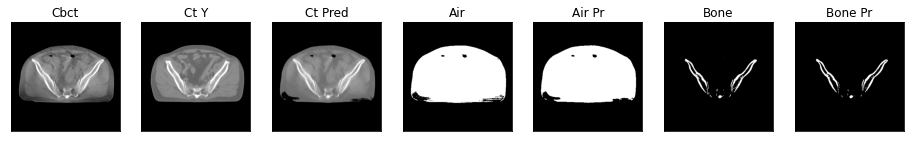

ssim score = 0.8230493664741516
psnr score = 22.475183486938477
snr score = 13.05016040802002
mae error = 0.030798640102148056
air dice score = 0.9911696026768618
bone dice score = 0.9404700634767461


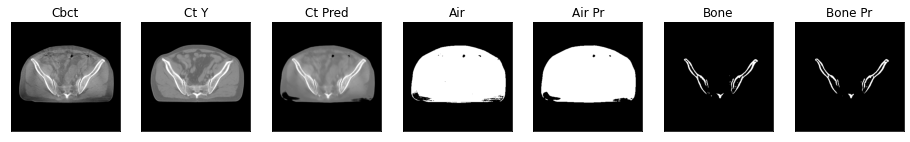

ssim score = 0.8262899518013
psnr score = 22.54532241821289
snr score = 13.119555473327637
mae error = 0.030451331287622452
air dice score = 0.9904399763241526
bone dice score = 0.9279354947097609


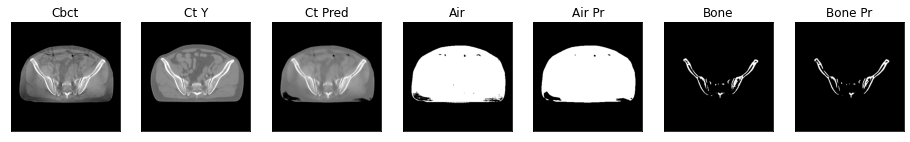

ssim score = 0.8851131796836853
psnr score = 24.67195701599121
snr score = 15.106090545654297
mae error = 0.021180834621191025
air dice score = 0.9983390311552616
bone dice score = 0.9682416731228412


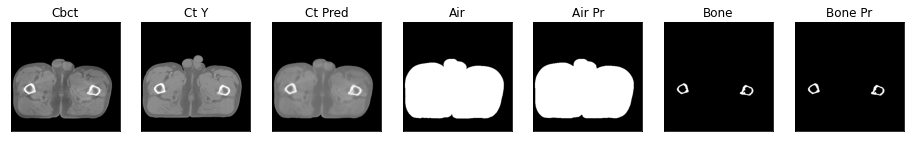

ssim score = 0.8832207918167114
psnr score = 24.914701461791992
snr score = 15.413227081298828
mae error = 0.020919231697916985
air dice score = 0.9982355677461798
bone dice score = 0.9635974304081514


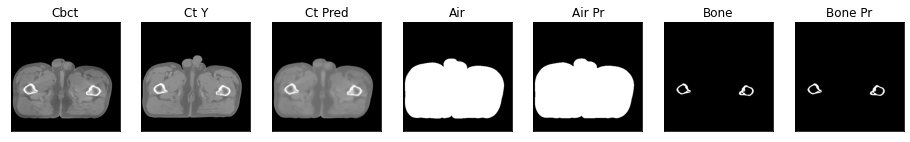

ssim score = 0.8898603916168213
psnr score = 26.499874114990234
snr score = 17.137615203857422
mae error = 0.01985747553408146
air dice score = 0.9980575442602431
bone dice score = 0.9639329198262363


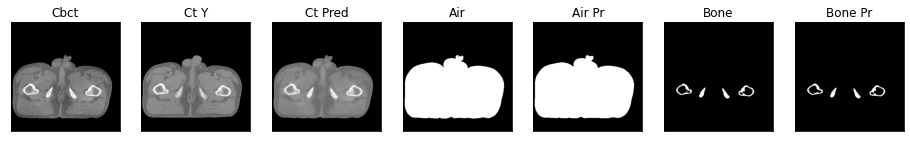

7it [00:43,  5.70s/it]

ssim score = 0.8912054300308228
psnr score = 26.307762145996094
snr score = 17.066991806030273
mae error = 0.020365912467241287
air dice score = 0.997902869757176
bone dice score = 0.9512464151786622


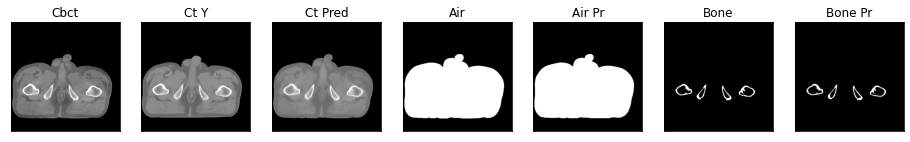

ssim score = 0.8880175352096558
psnr score = 26.138107299804688
snr score = 16.921512603759766
mae error = 0.02036699466407299
air dice score = 0.9980891569486289
bone dice score = 0.9380288131731528


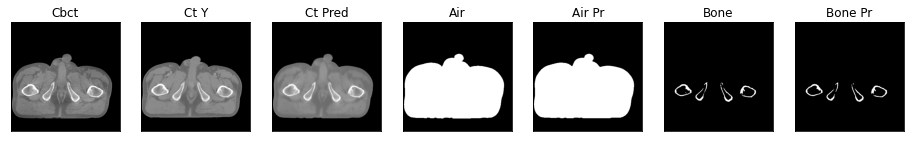

ssim score = 0.8888983726501465
psnr score = 26.06290626525879
snr score = 16.84191131591797
mae error = 0.02005896344780922
air dice score = 0.9979814481734871
bone dice score = 0.9367936375065552


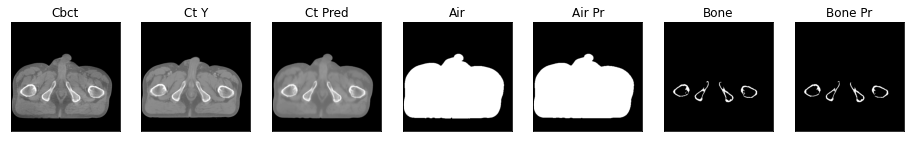

ssim score = 0.8898290395736694
psnr score = 25.603485107421875
snr score = 16.38874626159668
mae error = 0.020726237446069717
air dice score = 0.9979675275247012
bone dice score = 0.9288925214562956


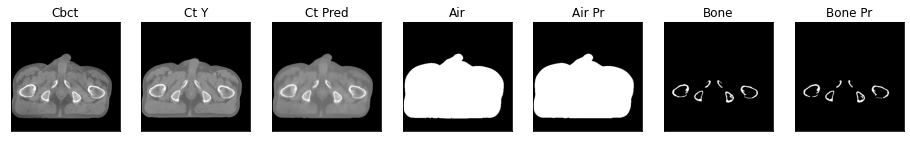

ssim score = 0.8882807493209839
psnr score = 25.370952606201172
snr score = 16.134658813476562
mae error = 0.020617270842194557
air dice score = 0.998012490671277
bone dice score = 0.9397736459187597


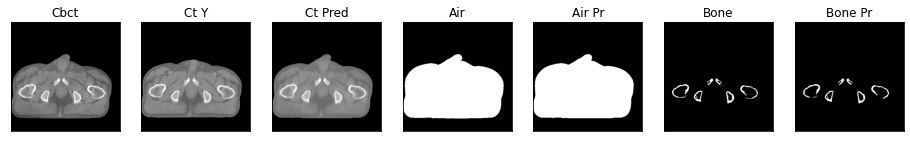

ssim score = 0.8889928460121155
psnr score = 25.396825790405273
snr score = 16.177440643310547
mae error = 0.02047775685787201
air dice score = 0.9984006302934817
bone dice score = 0.942550386137831


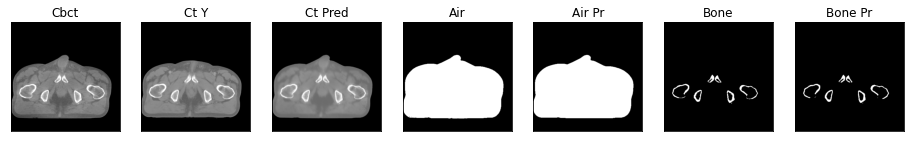

ssim score = 0.8895823359489441
psnr score = 25.717376708984375
snr score = 16.566585540771484
mae error = 0.020187070593237877
air dice score = 0.9986795809448518
bone dice score = 0.9458582408207369


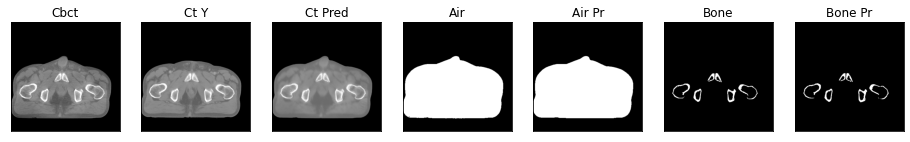

ssim score = 0.8900678157806396
psnr score = 26.165964126586914
snr score = 17.09653091430664
mae error = 0.019714048132300377
air dice score = 0.998721988934489
bone dice score = 0.9452906434574869


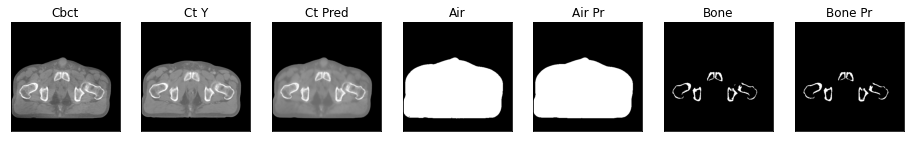

ssim score = 0.8916784524917603
psnr score = 26.658876419067383
snr score = 17.640148162841797
mae error = 0.019109878689050674
air dice score = 0.9985336074849787
bone dice score = 0.9242811982549408


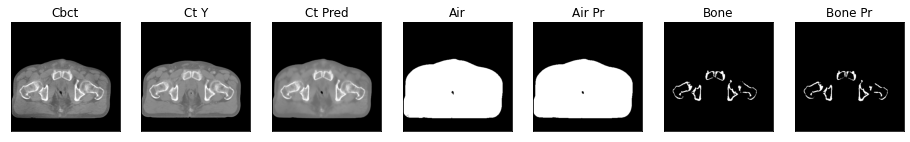

ssim score = 0.8948718905448914
psnr score = 27.191781997680664
snr score = 18.289321899414062
mae error = 0.018447136506438255
air dice score = 0.9980893298264423
bone dice score = 0.905001397039606


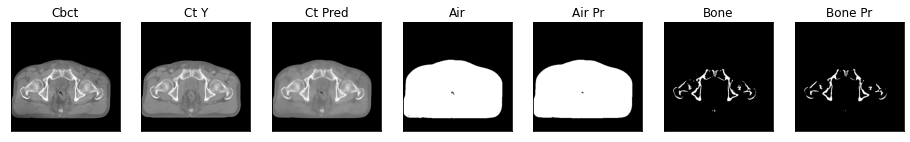

ssim score = 0.8953726887702942
psnr score = 26.809219360351562
snr score = 17.86852264404297
mae error = 0.01858348585665226
air dice score = 0.9977873079986822
bone dice score = 0.9016294508162096


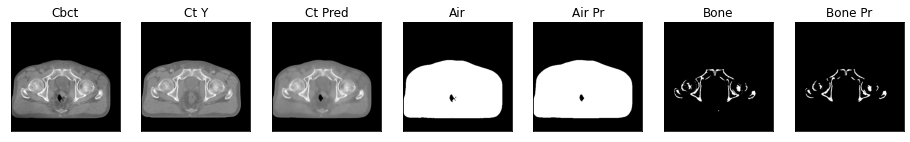

ssim score = 0.8917697668075562
psnr score = 26.023807525634766
snr score = 16.987442016601562
mae error = 0.019392767921090126
air dice score = 0.9974401690301106
bone dice score = 0.9044920525237803


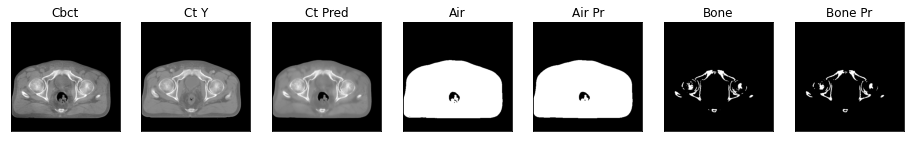

8it [00:46,  4.91s/it]

ssim score = 0.894301176071167
psnr score = 25.701570510864258
snr score = 16.505443572998047
mae error = 0.01975996233522892
air dice score = 0.9969471022025087
bone dice score = 0.91864874181457


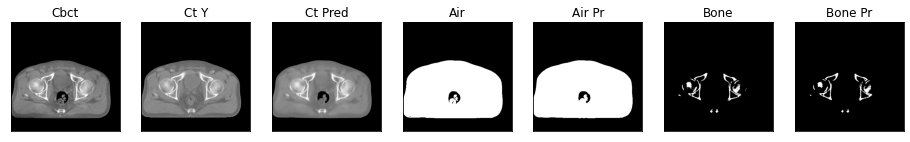

ssim score = 0.8922826647758484
psnr score = 25.25299835205078
snr score = 15.940446853637695
mae error = 0.020061355084180832
air dice score = 0.9972949497456283
bone dice score = 0.9101625290246443


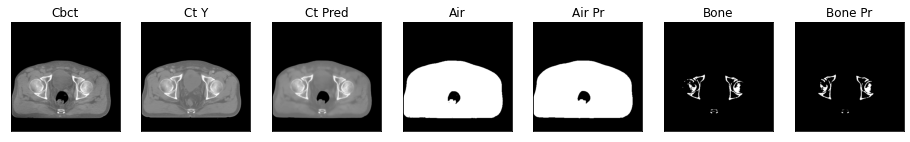

ssim score = 0.8880323171615601
psnr score = 25.146270751953125
snr score = 15.788625717163086
mae error = 0.019917786121368408
air dice score = 0.9969691418674774
bone dice score = 0.9345150172339649


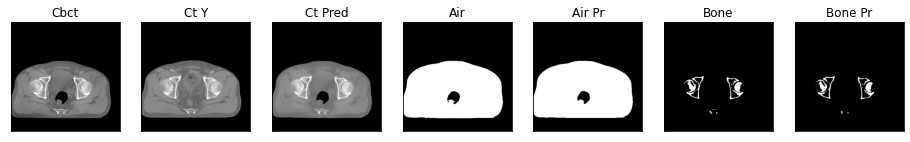

ssim score = 0.8823657631874084
psnr score = 24.503677368164062
snr score = 15.152706146240234
mae error = 0.02140299417078495
air dice score = 0.9968716892044106
bone dice score = 0.9489828866653377


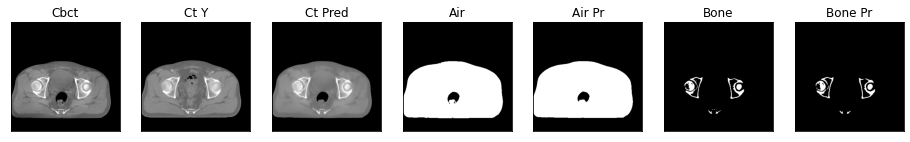

ssim score = 0.8847856521606445
psnr score = 24.083358764648438
snr score = 14.762492179870605
mae error = 0.022342033684253693
air dice score = 0.9970232620365596
bone dice score = 0.9601937339191737


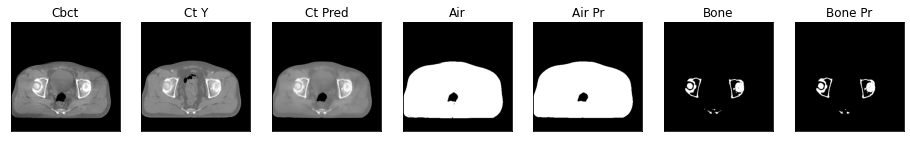

ssim score = 0.8910247087478638
psnr score = 24.783267974853516
snr score = 15.419815063476562
mae error = 0.021345162764191628
air dice score = 0.9967093174756985
bone dice score = 0.9473325379248793


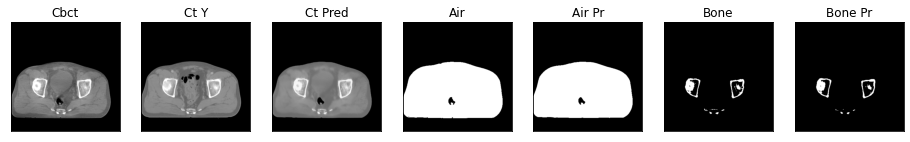

ssim score = 0.8926717638969421
psnr score = 25.129894256591797
snr score = 15.676237106323242
mae error = 0.020007045939564705
air dice score = 0.9966907113713888
bone dice score = 0.943889315911916


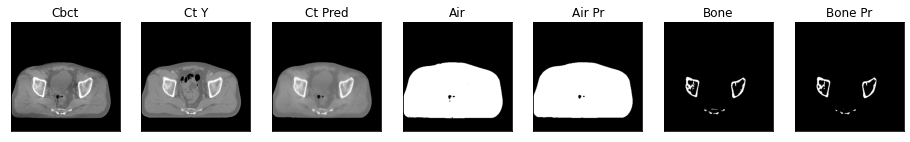

ssim score = 0.8932591080665588
psnr score = 24.757558822631836
snr score = 15.238176345825195
mae error = 0.02023235894739628
air dice score = 0.9969803341086936
bone dice score = 0.9557239728768304


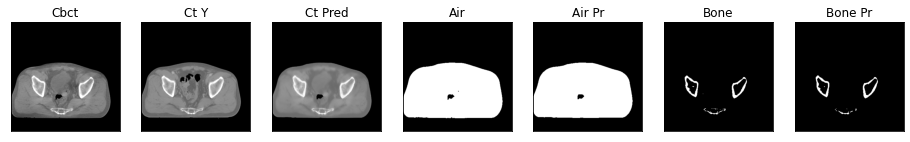

ssim score = 0.8913878202438354
psnr score = 24.787790298461914
snr score = 15.268104553222656
mae error = 0.02025899477303028
air dice score = 0.9964136282127944
bone dice score = 0.9526140933737959


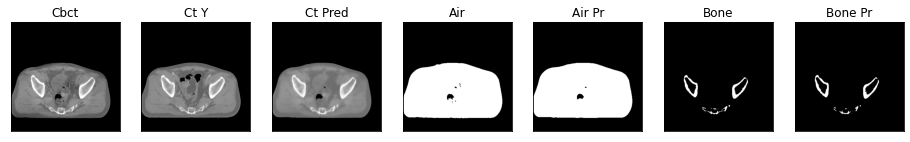

ssim score = 0.884200394153595
psnr score = 24.620418548583984
snr score = 15.176898002624512
mae error = 0.02146204374730587
air dice score = 0.996437413199689
bone dice score = 0.9509036573224576


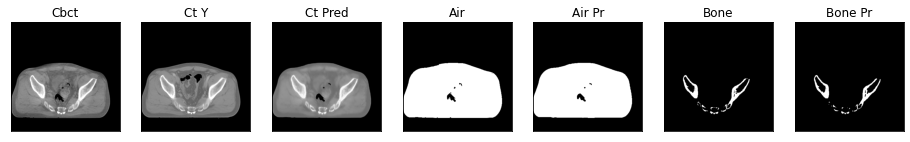

ssim score = 0.8908318877220154
psnr score = 24.904220581054688
snr score = 15.496280670166016
mae error = 0.020603591576218605
air dice score = 0.995051356311047
bone dice score = 0.9490942747593667


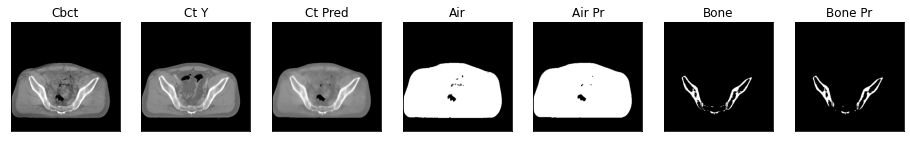

ssim score = 0.8921692371368408
psnr score = 25.587841033935547
snr score = 16.11820411682129
mae error = 0.019411910325288773
air dice score = 0.9955076213117086
bone dice score = 0.9312739124283509


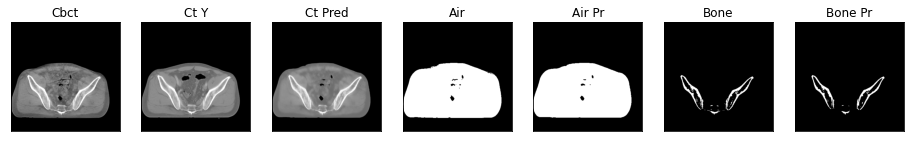

9it [00:49,  4.42s/it]

ssim score = 0.8883283138275146
psnr score = 25.262653350830078
snr score = 15.731755256652832
mae error = 0.019839512184262276
air dice score = 0.9952778145549271
bone dice score = 0.9311728853882686


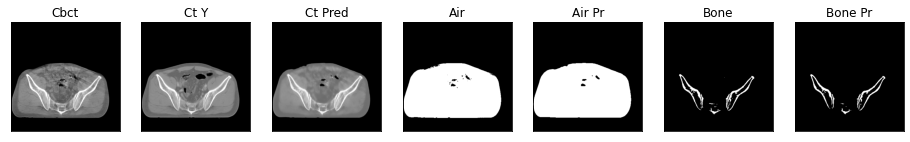

ssim score = 0.8222362399101257
psnr score = 22.5228214263916
snr score = 14.220128059387207
mae error = 0.030909491702914238
air dice score = 0.9986239245671353
bone dice score = 0.9839974898028241


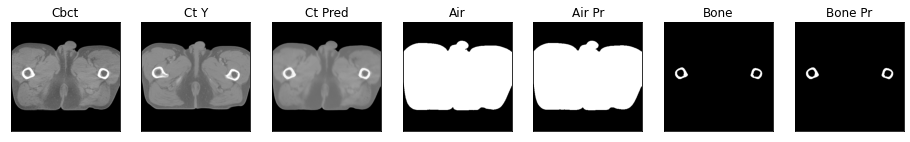

ssim score = 0.8126217126846313
psnr score = 22.207969665527344
snr score = 14.009567260742188
mae error = 0.03192298859357834
air dice score = 0.9987396256926121
bone dice score = 0.977362761743708


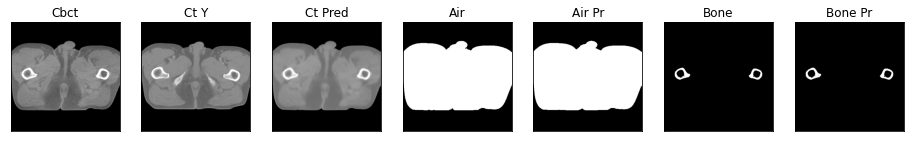

ssim score = 0.805708646774292
psnr score = 21.955232620239258
snr score = 13.884786605834961
mae error = 0.03351202234625816
air dice score = 0.9986728442606447
bone dice score = 0.9579139981711364


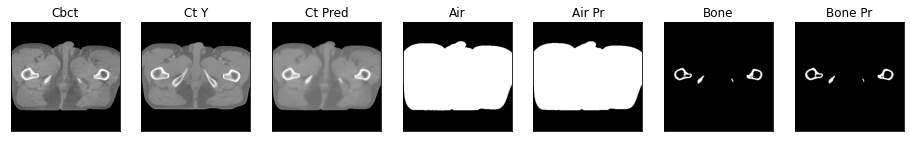

ssim score = 0.7991241812705994
psnr score = 21.72378158569336
snr score = 13.685623168945312
mae error = 0.034022439271211624
air dice score = 0.9986173318049146
bone dice score = 0.9625740897550792


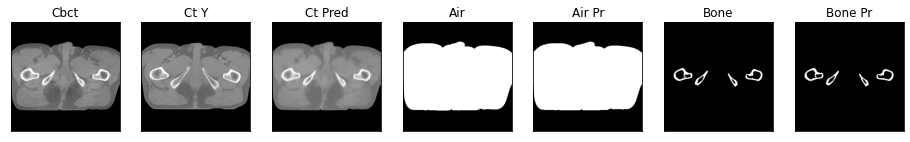

ssim score = 0.7903457880020142
psnr score = 21.61859130859375
snr score = 13.610671997070312
mae error = 0.03465990722179413
air dice score = 0.9983501850149672
bone dice score = 0.9485451257611616


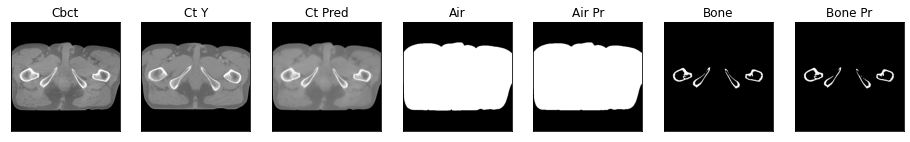

ssim score = 0.7823226451873779
psnr score = 21.481525421142578
snr score = 13.508023262023926
mae error = 0.035980600863695145
air dice score = 0.9982033185762779
bone dice score = 0.9508247743549514


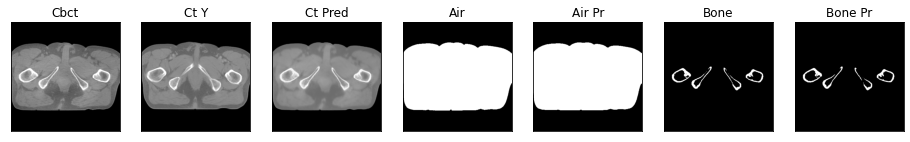

ssim score = 0.7755340933799744
psnr score = 21.194366455078125
snr score = 13.241174697875977
mae error = 0.03730882331728935
air dice score = 0.9982681753823481
bone dice score = 0.9545951859962446


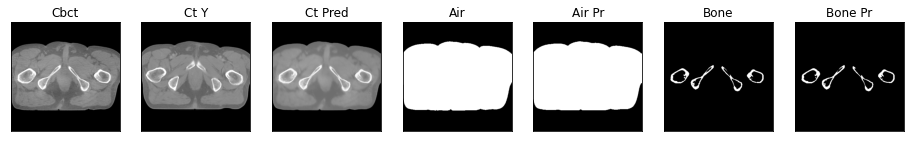

ssim score = 0.7754475474357605
psnr score = 21.282249450683594
snr score = 13.368130683898926
mae error = 0.03642592206597328
air dice score = 0.9986259318813047
bone dice score = 0.9535738597691821


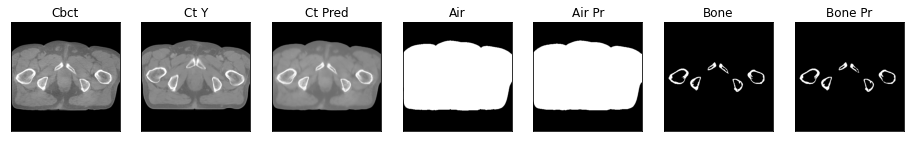

ssim score = 0.7756066918373108
psnr score = 21.429779052734375
snr score = 13.564340591430664
mae error = 0.03610870987176895
air dice score = 0.9989470728625586
bone dice score = 0.9529566360058744


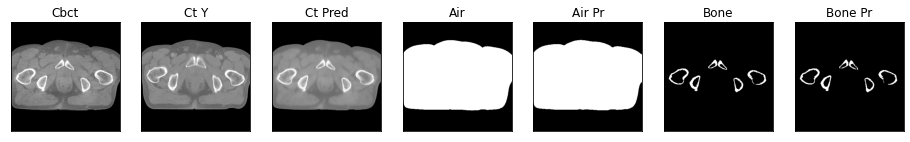

ssim score = 0.7698500156402588
psnr score = 21.303422927856445
snr score = 13.460596084594727
mae error = 0.037615466862916946
air dice score = 0.9988367674996353
bone dice score = 0.9523448363044831


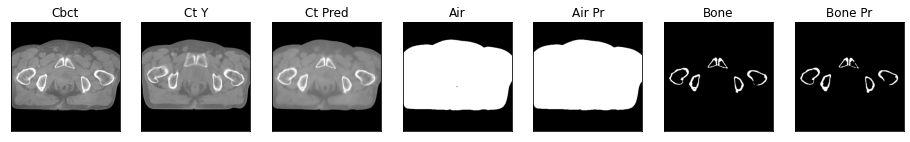

ssim score = 0.7567881941795349
psnr score = 21.215576171875
snr score = 13.41552734375
mae error = 0.038929570466279984
air dice score = 0.9985140812651878
bone dice score = 0.946770759404462


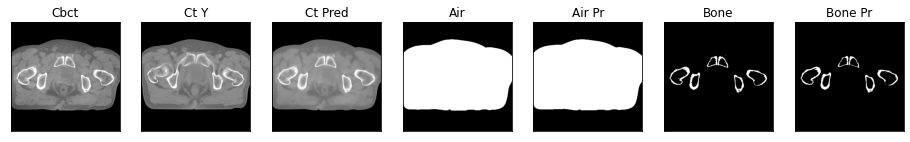

10it [00:53,  4.08s/it]

ssim score = 0.7545026540756226
psnr score = 21.192867279052734
snr score = 13.451156616210938
mae error = 0.03933582827448845
air dice score = 0.9983088179741858
bone dice score = 0.9484024179625604


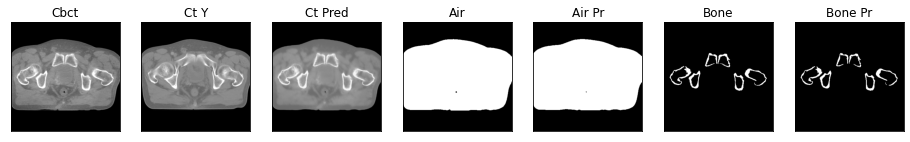

ssim score = 0.7458619475364685
psnr score = 20.932483673095703
snr score = 13.115400314331055
mae error = 0.041236091405153275
air dice score = 0.998369435917672
bone dice score = 0.9437297456550748


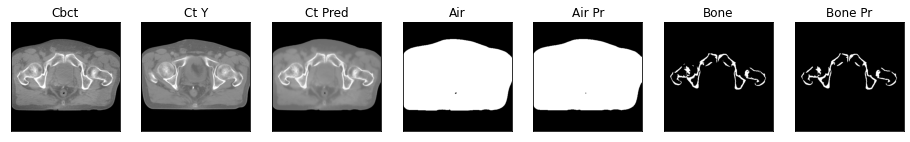

ssim score = 0.7507060766220093
psnr score = 20.82960319519043
snr score = 12.905301094055176
mae error = 0.04191000014543533
air dice score = 0.9983576589385728
bone dice score = 0.9296182028545158


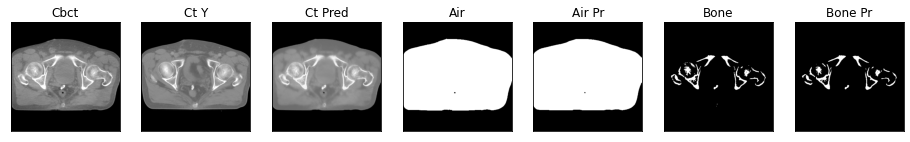

ssim score = 0.7640063762664795
psnr score = 21.02764892578125
snr score = 12.980260848999023
mae error = 0.04111674055457115
air dice score = 0.9983332268611825
bone dice score = 0.9343969967157729


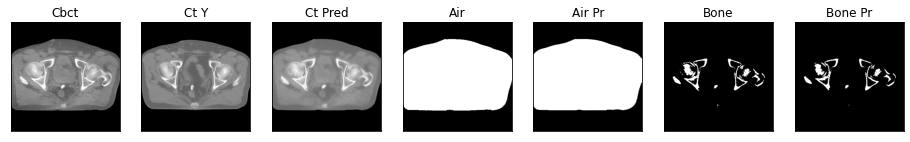

ssim score = 0.7699493765830994
psnr score = 21.227846145629883
snr score = 13.068028450012207
mae error = 0.03971923887729645
air dice score = 0.9982942604483834
bone dice score = 0.9471612712786858


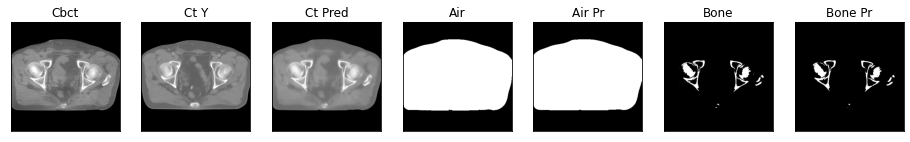

ssim score = 0.7682933807373047
psnr score = 21.498504638671875
snr score = 13.28803825378418
mae error = 0.03724004700779915
air dice score = 0.998254534416029
bone dice score = 0.9544902912625962


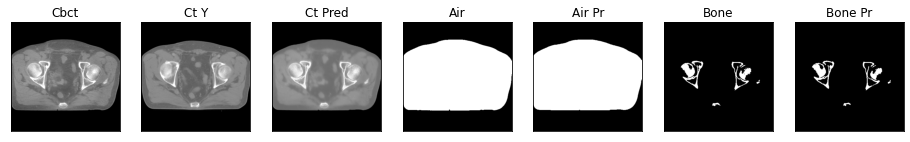

ssim score = 0.7662110328674316
psnr score = 21.309894561767578
snr score = 13.131584167480469
mae error = 0.03845001384615898
air dice score = 0.9982372611371726
bone dice score = 0.9482011270053294


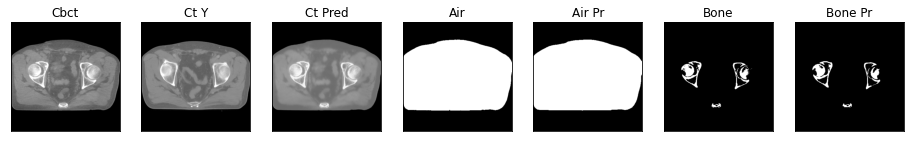

ssim score = 0.7651219367980957
psnr score = 21.076011657714844
snr score = 12.911177635192871
mae error = 0.03976159915328026
air dice score = 0.9981706205184625
bone dice score = 0.9503646200899745


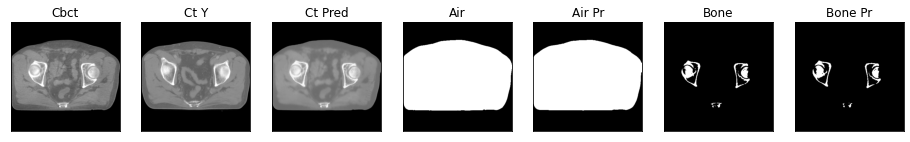

ssim score = 0.7616494297981262
psnr score = 20.713699340820312
snr score = 12.407374382019043
mae error = 0.04162692651152611
air dice score = 0.9983380943087132
bone dice score = 0.9603257707974366


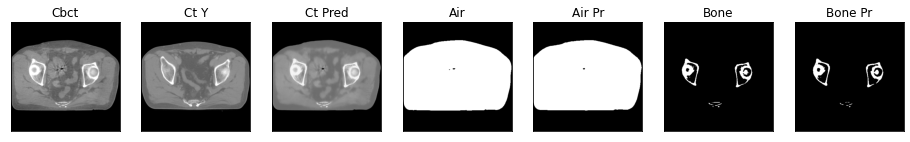

ssim score = 0.7704623937606812
psnr score = 20.7733154296875
snr score = 12.40768051147461
mae error = 0.04114881157875061
air dice score = 0.9983535523445544
bone dice score = 0.9578889800388585


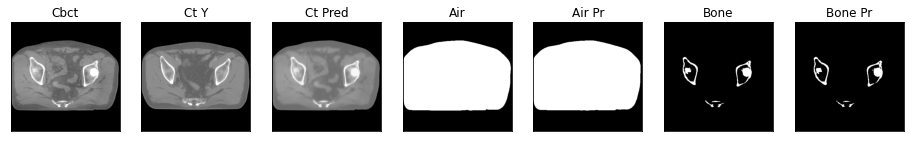

ssim score = 0.7696951031684875
psnr score = 21.07233238220215
snr score = 12.73234748840332
mae error = 0.03898024931550026
air dice score = 0.9984471122260058
bone dice score = 0.9346791087424361


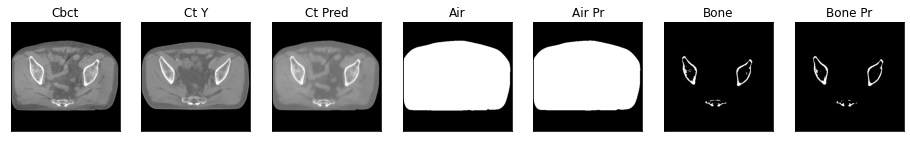

ssim score = 0.7649660706520081
psnr score = 20.972787857055664
snr score = 12.70561695098877
mae error = 0.03922289237380028
air dice score = 0.9982391297815449
bone dice score = 0.9464728819577016


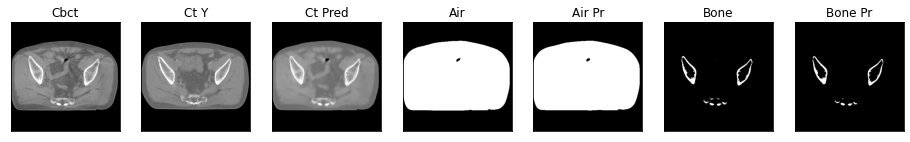

11it [00:56,  3.84s/it]

ssim score = 0.7564257383346558
psnr score = 20.631303787231445
snr score = 12.49336051940918
mae error = 0.04103311151266098
air dice score = 0.9980040644505745
bone dice score = 0.9532984977146751


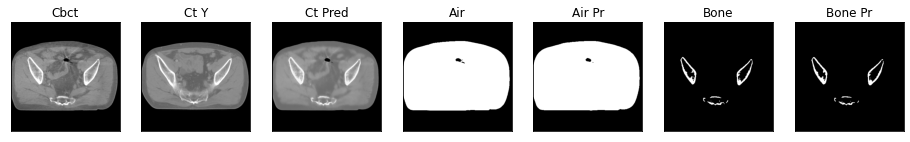

ssim score = 0.7493099570274353
psnr score = 20.47504234313965
snr score = 12.371058464050293
mae error = 0.0417928472161293
air dice score = 0.9982356877775761
bone dice score = 0.950394756443462


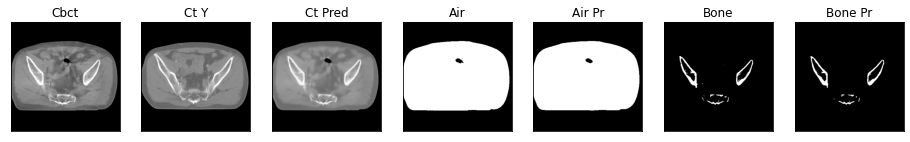

ssim score = 0.7400288581848145
psnr score = 20.485000610351562
snr score = 12.351227760314941
mae error = 0.04256296157836914
air dice score = 0.9983041749017896
bone dice score = 0.9436244858463146


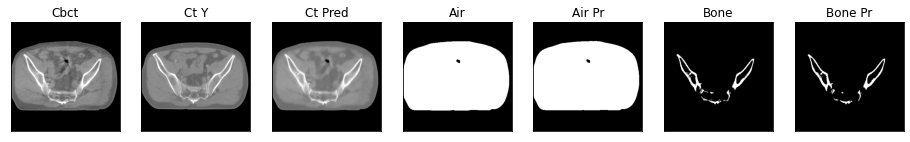

ssim score = 0.7391567230224609
psnr score = 20.695934295654297
snr score = 12.498784065246582
mae error = 0.04127316549420357
air dice score = 0.99827535593718
bone dice score = 0.9370017999493828


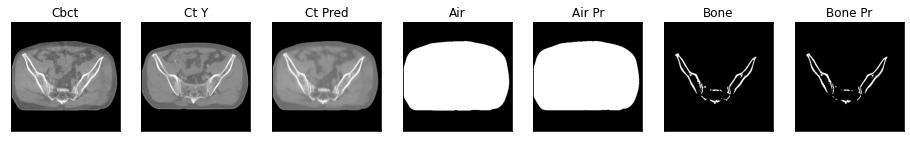

ssim score = 0.8545202016830444
psnr score = 23.54131507873535
snr score = 15.018706321716309
mae error = 0.02780822664499283
air dice score = 0.9972847139171594
bone dice score = 0.9285189718491001


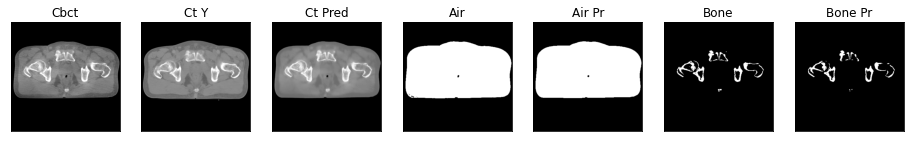

ssim score = 0.859226405620575
psnr score = 23.774288177490234
snr score = 15.2916898727417
mae error = 0.026427872478961945
air dice score = 0.9971822072207844
bone dice score = 0.9217791411052942


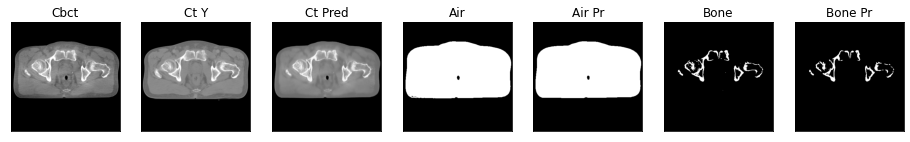

ssim score = 0.8593624234199524
psnr score = 23.940322875976562
snr score = 15.465511322021484
mae error = 0.0264742448925972
air dice score = 0.9972544464390795
bone dice score = 0.9115174162563524


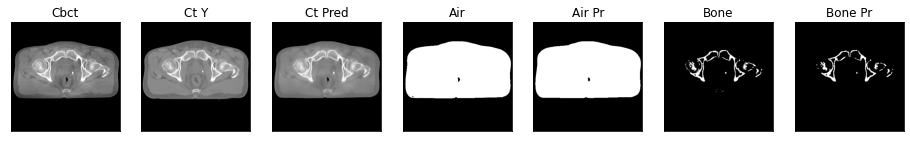

ssim score = 0.8638147115707397
psnr score = 24.024948120117188
snr score = 15.491722106933594
mae error = 0.02547335997223854
air dice score = 0.9971245667932888
bone dice score = 0.9185074254346873


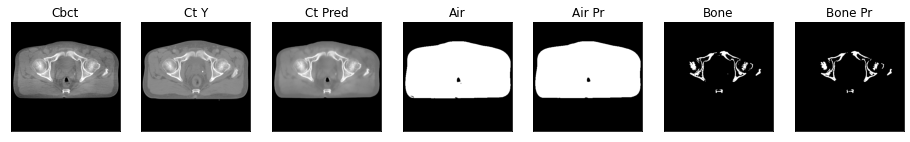

ssim score = 0.8706489205360413
psnr score = 24.23574447631836
snr score = 15.546892166137695
mae error = 0.02393919602036476
air dice score = 0.9973595556769573
bone dice score = 0.9127151917862774


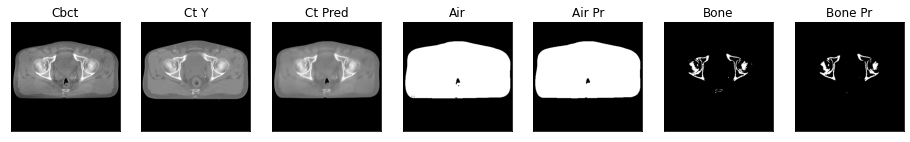

ssim score = 0.8733026385307312
psnr score = 24.375553131103516
snr score = 15.665895462036133
mae error = 0.023522742092609406
air dice score = 0.9977030028294155
bone dice score = 0.9320033717345884


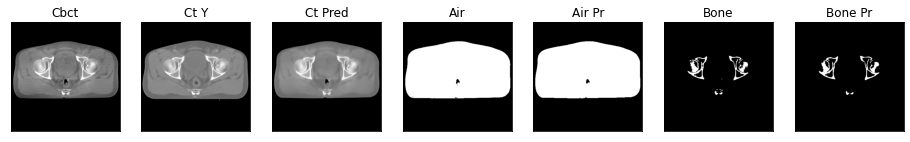

ssim score = 0.8716748952865601
psnr score = 24.359516143798828
snr score = 15.63422966003418
mae error = 0.02367987297475338
air dice score = 0.9975574383634855
bone dice score = 0.939589927068397


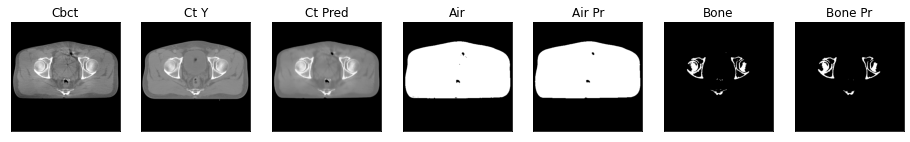

ssim score = 0.8654400110244751
psnr score = 23.76131820678711
snr score = 15.045394897460938
mae error = 0.024990761652588844
air dice score = 0.9975158708252848
bone dice score = 0.941388388527901


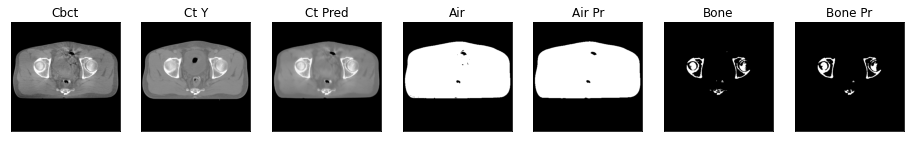

12it [00:59,  3.66s/it]

ssim score = 0.8616469502449036
psnr score = 23.7923526763916
snr score = 15.132209777832031
mae error = 0.025648871436715126
air dice score = 0.9962837863831191
bone dice score = 0.950121984278258


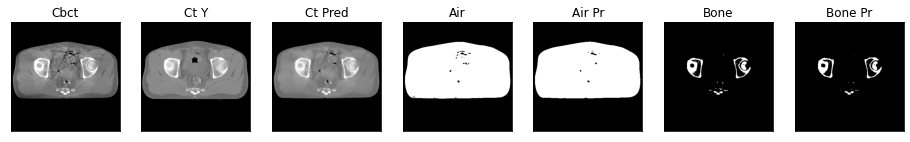

ssim score = 0.8610852956771851
psnr score = 23.401405334472656
snr score = 14.719332695007324
mae error = 0.0265188105404377
air dice score = 0.9958126610887114
bone dice score = 0.9480537470570986


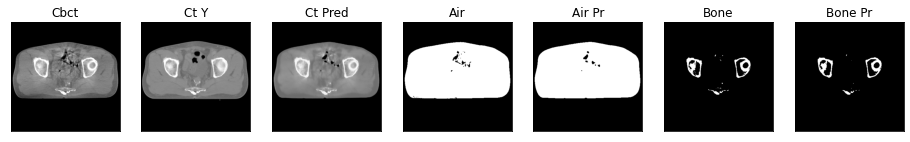

ssim score = 0.8611781597137451
psnr score = 22.731632232666016
snr score = 13.978788375854492
mae error = 0.027254382148385048
air dice score = 0.9957515553035691
bone dice score = 0.9381459200996738


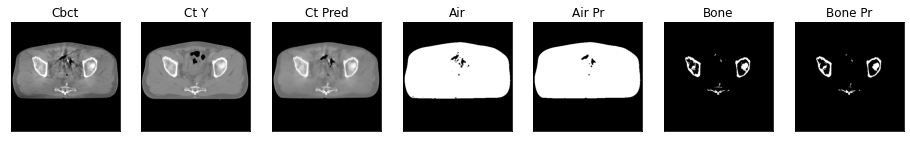

ssim score = 0.8630527853965759
psnr score = 23.09906768798828
snr score = 14.302329063415527
mae error = 0.026319419965147972
air dice score = 0.9966313763233905
bone dice score = 0.9393539881354753


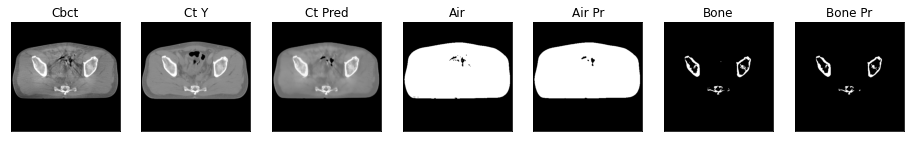

ssim score = 0.8655929565429688
psnr score = 23.43692398071289
snr score = 14.639086723327637
mae error = 0.02564386837184429
air dice score = 0.9963791532669409
bone dice score = 0.9445961136992999


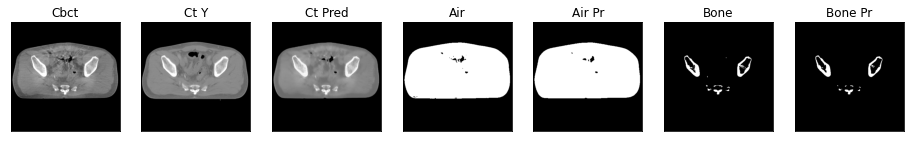

ssim score = 0.862168550491333
psnr score = 23.446819305419922
snr score = 14.662341117858887
mae error = 0.025869742035865784
air dice score = 0.9961474785992859
bone dice score = 0.9451657247602694


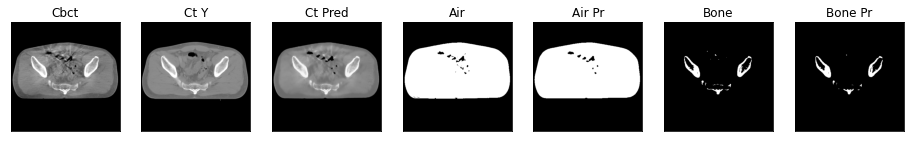

ssim score = 0.8594203591346741
psnr score = 23.432483673095703
snr score = 14.703208923339844
mae error = 0.02612195536494255
air dice score = 0.9960059556164803
bone dice score = 0.9492212232499782


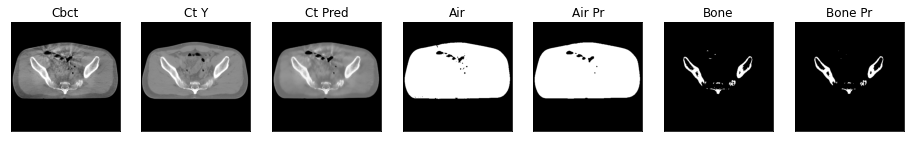

ssim score = 0.8600710034370422
psnr score = 22.864402770996094
snr score = 14.154499053955078
mae error = 0.026927858591079712
air dice score = 0.9964718975192811
bone dice score = 0.9419573138997663


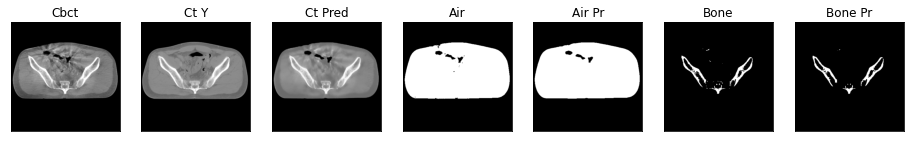

ssim score = 0.8648050427436829
psnr score = 22.989492416381836
snr score = 14.224849700927734
mae error = 0.0259691271930933
air dice score = 0.9963868158222784
bone dice score = 0.9342709529286126


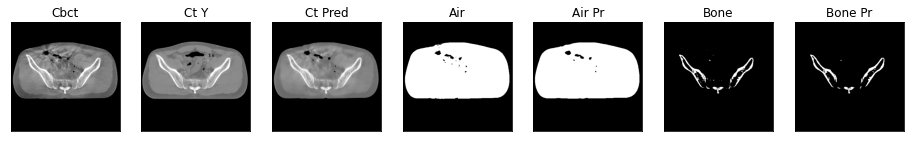

ssim score = 0.8655958771705627
psnr score = 23.299789428710938
snr score = 14.49879264831543
mae error = 0.025347992777824402
air dice score = 0.9966396209933213
bone dice score = 0.9264006913448596


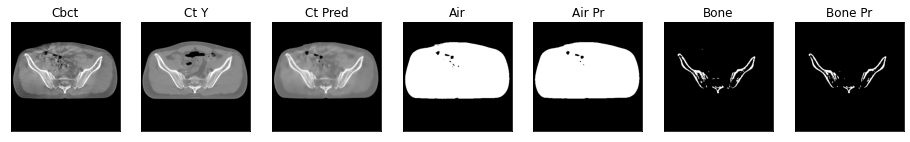

ssim score = 0.8696709871292114
psnr score = 23.52714729309082
snr score = 14.726223945617676
mae error = 0.02442578226327896
air dice score = 0.9969781862822272
bone dice score = 0.9213191378872849


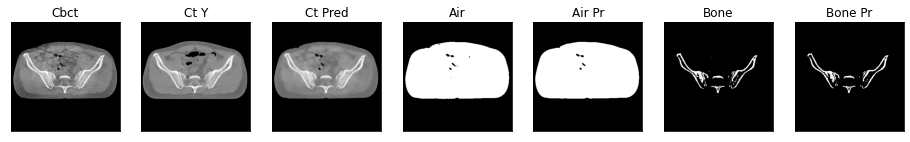

ssim score = 0.8672277331352234
psnr score = 23.61405372619629
snr score = 14.811710357666016
mae error = 0.024385269731283188
air dice score = 0.9971995424604605
bone dice score = 0.9275400367560049


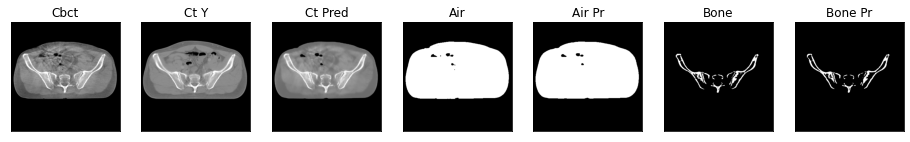

13it [01:03,  3.54s/it]

ssim score = 0.8580653667449951
psnr score = 22.9715518951416
snr score = 14.174242973327637
mae error = 0.025813864544034004
air dice score = 0.9963464807078326
bone dice score = 0.9215558735537719


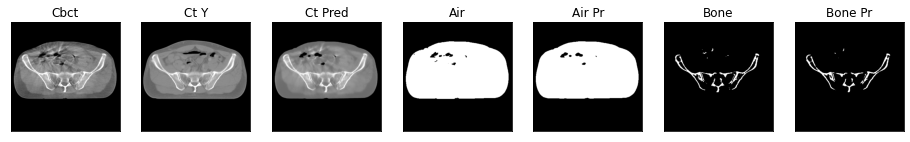

ssim score = 0.8537969589233398
psnr score = 22.544342041015625
snr score = 13.729761123657227
mae error = 0.02674960158765316
air dice score = 0.9962425250231874
bone dice score = 0.9191709844570055


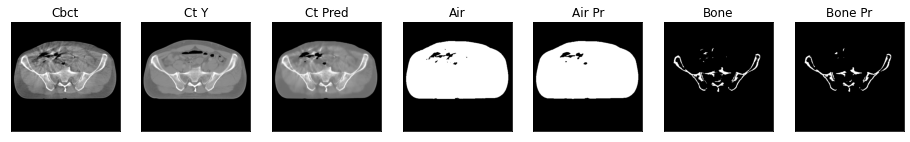

ssim score = 0.8503483533859253
psnr score = 22.246883392333984
snr score = 13.413679122924805
mae error = 0.0276504997164011
air dice score = 0.9960785571656581
bone dice score = 0.9193213719038286


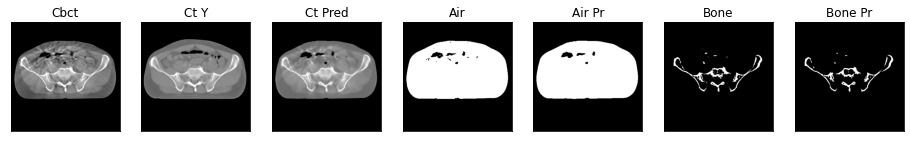

ssim score = 0.8407113552093506
psnr score = 21.79327392578125
snr score = 12.914133071899414
mae error = 0.029208103194832802
air dice score = 0.9961508728982831
bone dice score = 0.9121517486673129


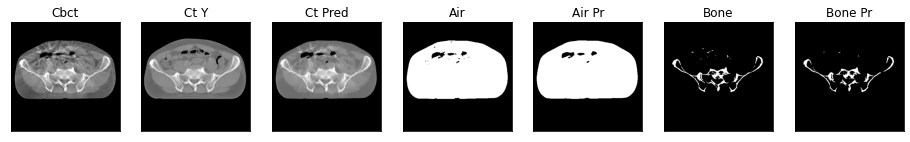

ssim score = 0.8361040353775024
psnr score = 21.793062210083008
snr score = 12.860122680664062
mae error = 0.029285335913300514
air dice score = 0.9963093657936513
bone dice score = 0.9195082347492517


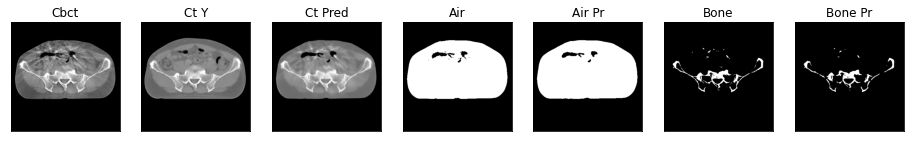

ssim score = 0.8270187377929688
psnr score = 21.41640853881836
snr score = 12.513932228088379
mae error = 0.031136317178606987
air dice score = 0.9967266908712877
bone dice score = 0.9292586304478861


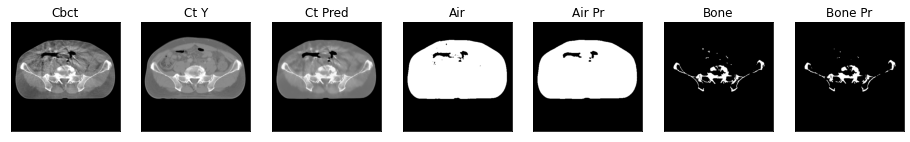

ssim score = 0.8206319212913513
psnr score = 21.17700958251953
snr score = 12.21930980682373
mae error = 0.031448908150196075
air dice score = 0.9968866091678411
bone dice score = 0.9166666666676672


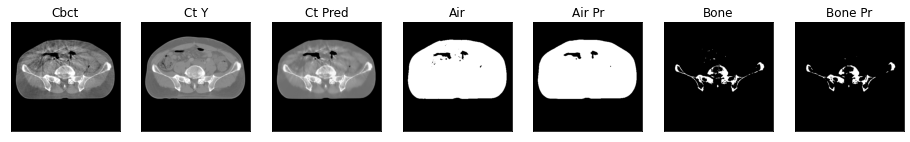

ssim score = 0.8328240513801575
psnr score = 22.007572174072266
snr score = 12.902338027954102
mae error = 0.028181804344058037
air dice score = 0.9971095449969171
bone dice score = 0.9271740502344166


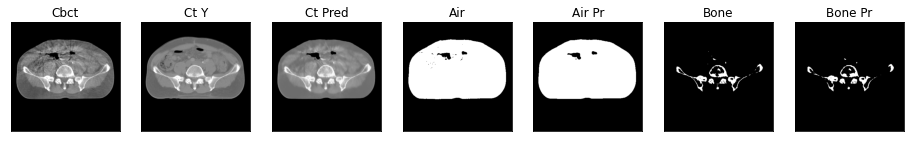

ssim score = 0.8799286484718323
psnr score = 26.391555786132812
snr score = 16.77246856689453
mae error = 0.01770489476621151
air dice score = 0.9979347500748295
bone dice score = 0.9622485533215143


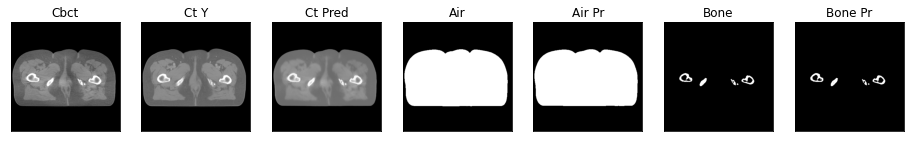

ssim score = 0.8800354599952698
psnr score = 26.50314712524414
snr score = 17.00507354736328
mae error = 0.017798075452446938
air dice score = 0.9978212535599841
bone dice score = 0.9661925856850969


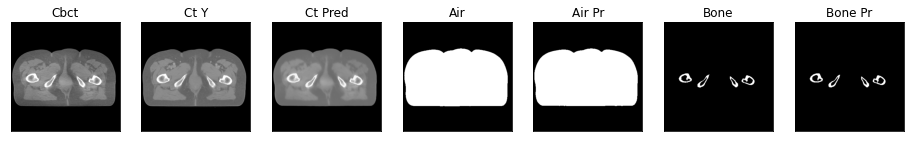

ssim score = 0.8774141073226929
psnr score = 26.48746109008789
snr score = 17.072298049926758
mae error = 0.018064910545945168
air dice score = 0.9976343958838506
bone dice score = 0.949080921192709


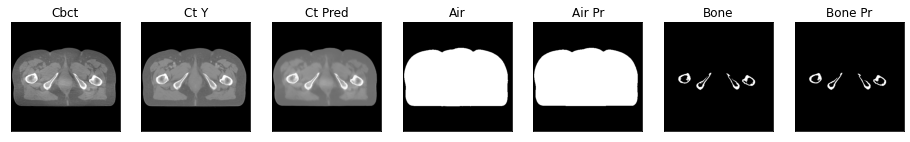

ssim score = 0.8751111030578613
psnr score = 26.440502166748047
snr score = 17.088787078857422
mae error = 0.018371589481830597
air dice score = 0.9978010340288161
bone dice score = 0.944266011714637


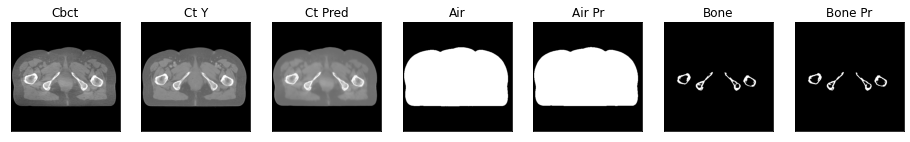

14it [01:06,  3.46s/it]

ssim score = 0.8747631907463074
psnr score = 26.2946720123291
snr score = 16.971420288085938
mae error = 0.01863178052008152
air dice score = 0.9979401092255266
bone dice score = 0.9528758287053776


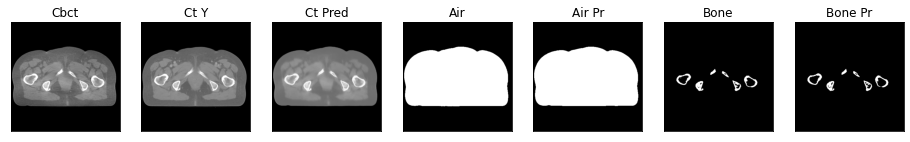

ssim score = 0.8762621283531189
psnr score = 26.234731674194336
snr score = 16.93443489074707
mae error = 0.018528928980231285
air dice score = 0.9976304010765602
bone dice score = 0.9526649273210461


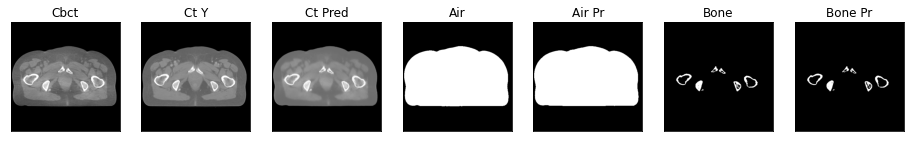

ssim score = 0.8729814291000366
psnr score = 26.152568817138672
snr score = 16.883596420288086
mae error = 0.018744120374321938
air dice score = 0.9978256428217043
bone dice score = 0.9507533994863883


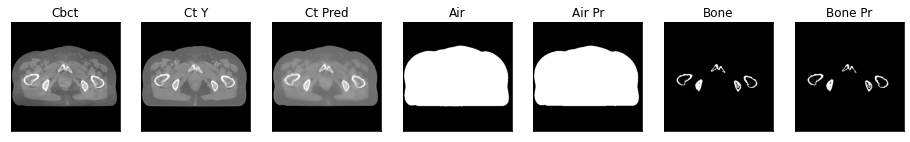

ssim score = 0.8721182346343994
psnr score = 25.84215545654297
snr score = 16.621551513671875
mae error = 0.019479908049106598
air dice score = 0.9976581821365275
bone dice score = 0.9499279538913918


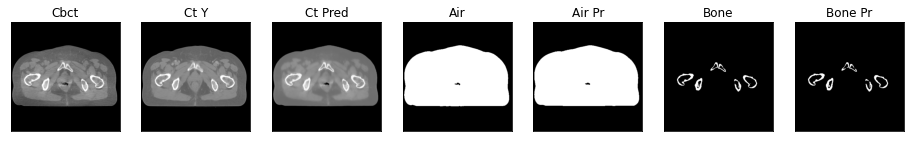

ssim score = 0.8726656436920166
psnr score = 25.61775016784668
snr score = 16.43988800048828
mae error = 0.019466634839773178
air dice score = 0.997767303398662
bone dice score = 0.9470176607806229


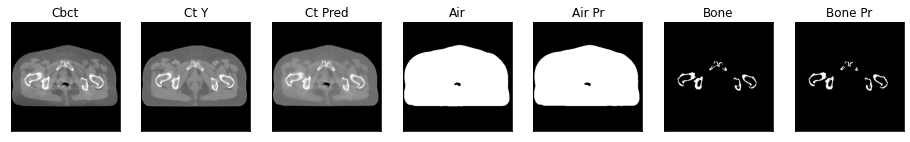

ssim score = 0.8712701201438904
psnr score = 25.491565704345703
snr score = 16.401405334472656
mae error = 0.019779274240136147
air dice score = 0.9977372923418311
bone dice score = 0.9433635970609113


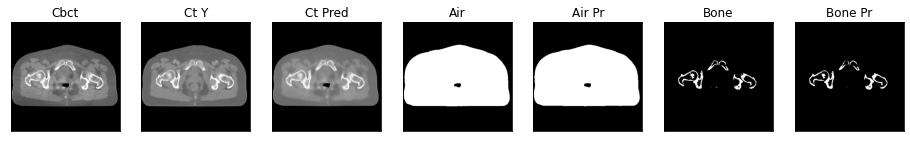

ssim score = 0.8762443661689758
psnr score = 26.58221435546875
snr score = 17.605327606201172
mae error = 0.0188011284917593
air dice score = 0.998024576591234
bone dice score = 0.9462365591404271


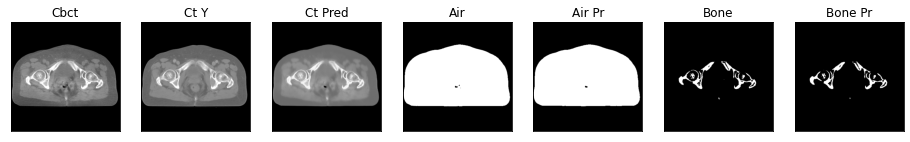

ssim score = 0.8788923025131226
psnr score = 25.81941795349121
snr score = 16.713979721069336
mae error = 0.01885252445936203
air dice score = 0.9977065055153098
bone dice score = 0.9313082499148894


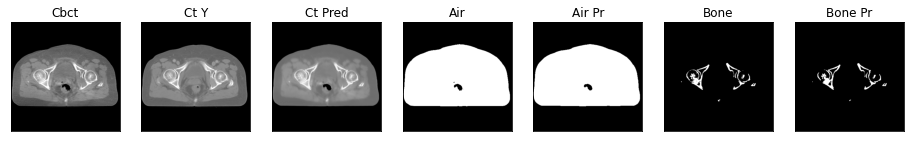

ssim score = 0.8811273574829102
psnr score = 26.077869415283203
snr score = 16.863006591796875
mae error = 0.01815587654709816
air dice score = 0.9977095073622995
bone dice score = 0.9210372392294592


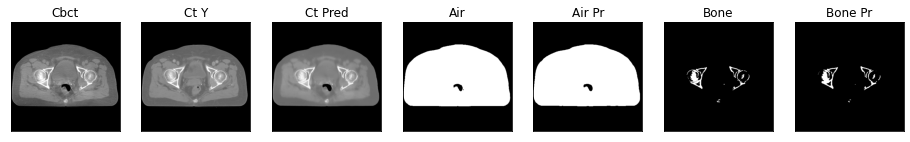

ssim score = 0.8836127519607544
psnr score = 26.001541137695312
snr score = 16.759553909301758
mae error = 0.018692342564463615
air dice score = 0.9978042364467778
bone dice score = 0.9317548746529987


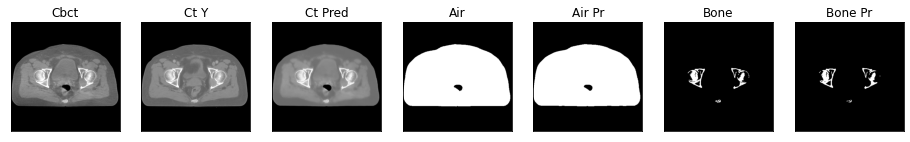

ssim score = 0.8854826092720032
psnr score = 26.61899757385254
snr score = 17.36900520324707
mae error = 0.01868489198386669
air dice score = 0.9977585562803545
bone dice score = 0.9429479672085838


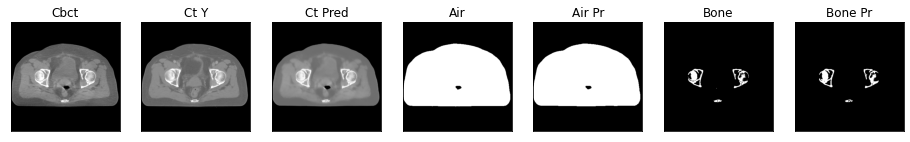

ssim score = 0.8850898146629333
psnr score = 27.35356330871582
snr score = 18.137800216674805
mae error = 0.0177100021392107
air dice score = 0.9979297833742411
bone dice score = 0.9560789306181401


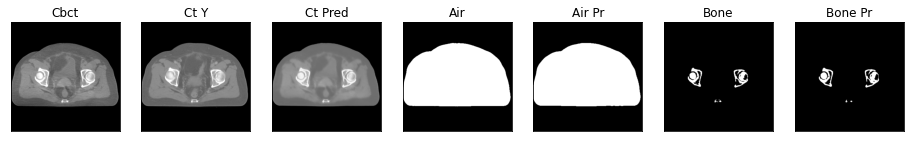

15it [01:09,  3.34s/it]

ssim score = 0.8778375387191772
psnr score = 26.59757423400879
snr score = 17.433303833007812
mae error = 0.01888091117143631
air dice score = 0.9978527434028381
bone dice score = 0.962150127227065


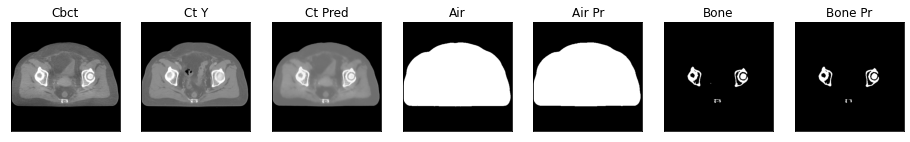

ssim score = 0.8665446043014526
psnr score = 25.579471588134766
snr score = 16.452754974365234
mae error = 0.02050081454217434
air dice score = 0.997723627347292
bone dice score = 0.9632340128948731


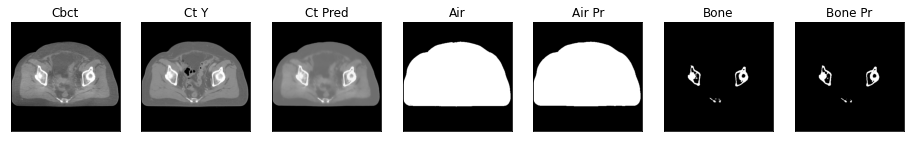

ssim score = 0.850780725479126
psnr score = 23.97028160095215
snr score = 14.77113151550293
mae error = 0.023329485207796097
air dice score = 0.9970319793771357
bone dice score = 0.9508196721322519


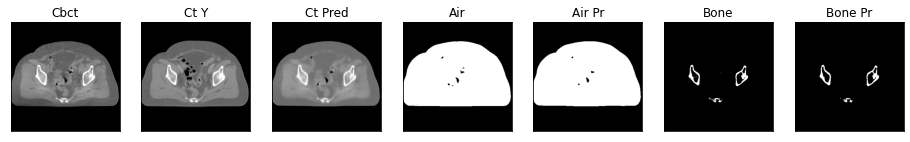

ssim score = 0.8450434803962708
psnr score = 23.702190399169922
snr score = 14.485045433044434
mae error = 0.024162424728274345
air dice score = 0.9968403109799215
bone dice score = 0.958248702325474


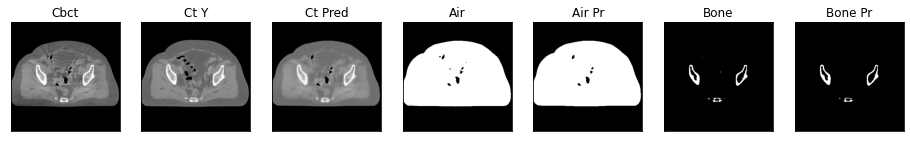

ssim score = 0.8435683846473694
psnr score = 24.205751419067383
snr score = 15.053522109985352
mae error = 0.023641124367713928
air dice score = 0.9970847080935383
bone dice score = 0.9570712573554789


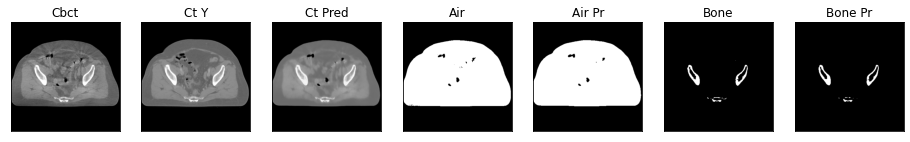

ssim score = 0.8456130027770996
psnr score = 24.40679931640625
snr score = 15.309663772583008
mae error = 0.0233529731631279
air dice score = 0.9968913467882939
bone dice score = 0.958279250881545


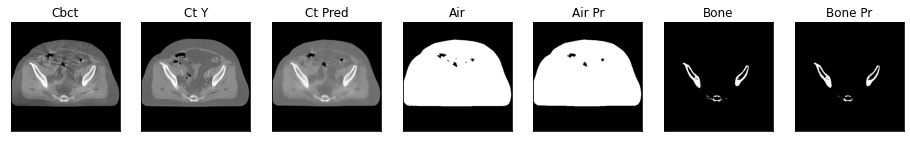

ssim score = 0.8411303758621216
psnr score = 23.71320343017578
snr score = 14.680498123168945
mae error = 0.024812152609229088
air dice score = 0.996989959798794
bone dice score = 0.9529887920306197


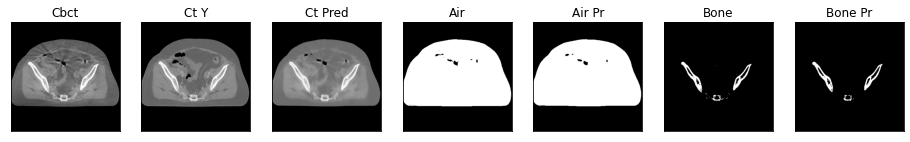

ssim score = 0.8415118455886841
psnr score = 23.594654083251953
snr score = 14.634805679321289
mae error = 0.025118451565504074
air dice score = 0.9965534285370796
bone dice score = 0.9442422477806923


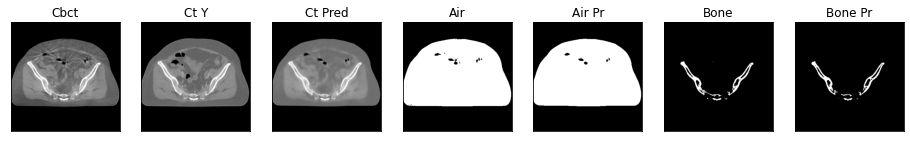

ssim score = 0.8413633704185486
psnr score = 23.51791000366211
snr score = 14.5537748336792
mae error = 0.025488514453172684
air dice score = 0.9967583477517273
bone dice score = 0.9342785408368885


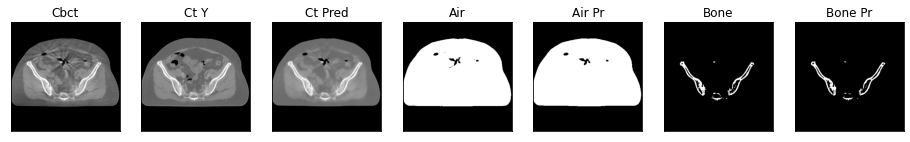

ssim score = 0.8402762413024902
psnr score = 23.632343292236328
snr score = 14.646028518676758
mae error = 0.025238022208213806
air dice score = 0.9966640669546033
bone dice score = 0.9411430196198302


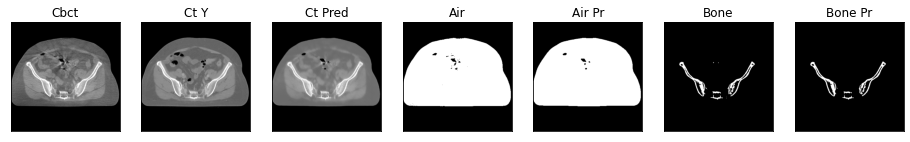

ssim score = 0.8464223146438599
psnr score = 24.427888870239258
snr score = 15.453210830688477
mae error = 0.02365819178521633
air dice score = 0.9971980438194832
bone dice score = 0.934350231794013


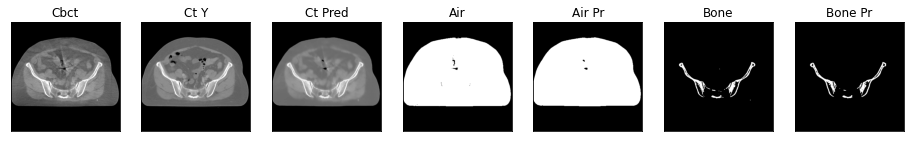

16it [01:12,  4.53s/it]


In [33]:
test_epoch(model, testloader, device, True, os.path.join("eval-unet", run_name))

In [31]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test
eval_epoch(model, testloader, device)

16it [00:02,  5.94it/s]


(0.853329386562109,
 23.72843563556671,
 14.74943083524704,
 0.025729317334480584,
 0.9969881538079726,
 0.9472498585987038)